In [1]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(glue)
    library(ggpointdensity)
})

In [97]:
options(repr.plot.width=10, repr.plot.height=6)
theme_set(theme_custom())

In [3]:
root <- "/lab/work/vivekrai/2021-06_pilot-rfx6/"

In [4]:
barcode_mapping <- data.frame(
    atac_barcode = read.table("/home/porchard/github/snATACseq-NextFlow/737K-arc-v1.txt", header = F)[[1]],
    rna_barcode = read.table("/home/porchard/github/snRNAseq-NextFlow/737K-arc-v1.txt", header = F)[[1]]
)

In [160]:
sample_table <- read.table(glue("{root}/data/sample_table.txt"), sep = "\t", header = T)
head(sample_table)

,Donor,Tube,Pseudoislet,Center,Donor_info
,<chr>,<int>,<chr>,<chr>,<chr>
1,16191825,1,W-shRNA-Scramble-mKate2,SC,25yM-ND
2,16191825,2,W-shRNA-RFX6-2896-mKate2,SC,25yM-ND
3,16515959,1,W-shRNA-RFX6-2896-mKate2,SC,51yF-ND
4,16515959,2,W-shRNA-SCR-mCherry,SC,51yF-ND
5,16550021,1,W-shRNA-SCR-mCherry,SC,50yF-ND
6,16550021,2,W-shRNA-RFX6-2896-mKate2,SC,50yF-ND


In [25]:
head(barcode_mapping)

,atac_barcode,rna_barcode
,<chr>,<chr>
1,ACAGCGGGTGTGTTAC,AAACAGCCAAACAACA
2,ACAGCGGGTTGTTCTT,AAACAGCCAAACATAG
3,ACAGCGGGTAACAGGC,AAACAGCCAAACCCTA
4,ACAGCGGGTGCGCGAA,AAACAGCCAAACCTAT
5,ACAGCGGGTCCTCCAT,AAACAGCCAAACCTTG
6,ACAGCGGGTCATGGTT,AAACAGCCAAACGCGA


In [6]:
## Load data
rna_qc <- lapply(list.files(glue("{root}/work/rnaseq/qc"), ".txt", full.names = T), function(x) {
    df <- read.table(x, header = T)
    df$Sample <- gsub(".qc.txt", "", basename(x))
    df
}) %>% bind_rows()

rna_qc$Sample <- gsub("-hg19-mCherry-mKate2", "", rna_qc$Sample)
rna_qc$umis <- as.integer(rna_qc$umis)

Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"


In [7]:
head(rna_qc); dim(rna_qc)

,barcode,total_reads,uniquely_mapped_reads,secondary_alignments,supplementary_alignments,umis,fraction_mitochondrial,Sample
,<chr>,<int>,<int>,<int>,<int>,<int>,<dbl>,<chr>
1,ATTTAGGTCGCTTCTA,1541813,1404975,108911,0,660955,0.006064165,3528_CV1
2,CCGTTTGGTCTTGCTG,236205,206483,23689,0,111684,0.061917930,3528_CV1
3,CTCTATGTCATGCATA,313329,288432,19958,0,132041,0.001164919,3528_CV1
4,TCCTTTACAATCCTAG,168183,144760,16874,0,72008,0.043382150,3528_CV1
5,TTAGCAATCGGTAACT,51570,46431,3825,0,20756,0.003036764,3528_CV1
6,ATCCCGCGTTCCATTA,287,129,119,0,77,0.062015504,3528_CV1


[1] 1411823       8

In [12]:
atac_libs = c("3528_ATAC_CV1", "3528_ATAC_CV2")
ataqv_metrics <- glue("{root}work/atacseq/ataqv/{atac_libs}.metrics.txt")
atac_qc <- lapply(ataqv_metrics, function(x) {
    df <- read.table(x, header = F)
    colnames(df) <- c("Sample", "Barcode", "Metric", "Value")
    df$Sample <- gsub("_ATAC", "", gsub("-hg19-mCherry-mKate2.ataqv.json.gz", "", basename(df$Sample)))
    df$Value <- as.numeric(df$Value)
    df
}) %>% bind_rows()

Warning message in FUN(X[[i]], ...):
"NAs introduced by coercion"
Warning message in FUN(X[[i]], ...):
"NAs introduced by coercion"


In [48]:
atac_qc <- atac_qc %>% pivot_wider(id_cols = c(Sample, Barcode), names_from = Metric, values_from = Value)

In [49]:
head(atac_qc); dim(atac_qc)

Sample,Barcode,tss_enrichment,percent_hqaa,hqaa,total_reads,total_autosomal_reads,percent_mitochondrial,percent_autosomal_duplicate,percent_duplicate,max_fraction_reads_from_single_autosome
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3528_CV1,AAACAAGCAAACATGT,2.713178,56.95306,1286,2258,1902,0.17714792,30.178759,27.05934,0.09486781
3528_CV1,AAACAAGCAAACCCAA,1.293103,53.50488,1206,2254,1760,1.86335404,29.204545,26.30878,0.08540630
3528_CV1,AAACAAGCAAAGAAGC,6.493506,10.13128,1173,11578,1671,0.03454828,2.692998,1.00190,0.09207161
3528_CV1,AAACAAGCAAATGAAG,2.094241,47.98729,906,1888,1440,0.42372881,35.138889,28.60169,0.09050773
3528_CV1,AAACAAGCAACAACAT,2.474227,53.64078,1768,3296,2585,0.24271845,28.974855,25.06068,0.09841629
3528_CV1,AAACAAGCAACATAGT,1.900739,54.13682,3023,5584,4482,0.35816619,29.339581,26.14613,0.09096924


[1] 155614     11

In [50]:
comb_df <- left_join(
    left_join(atac_qc, barcode_mapping, by = c("Barcode" = "atac_barcode")),
    rna_qc,
    by = c("Sample", "rna_barcode" = "barcode")
)

In [51]:
head(comb_df);
dim(comb_df)

Sample,Barcode,tss_enrichment,percent_hqaa,hqaa,total_reads.x,total_autosomal_reads,percent_mitochondrial,percent_autosomal_duplicate,percent_duplicate,max_fraction_reads_from_single_autosome,rna_barcode,total_reads.y,uniquely_mapped_reads,secondary_alignments,supplementary_alignments,umis,fraction_mitochondrial
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<int>,<int>,<int>,<int>,<dbl>
3528_CV1,AAACAAGCAAACATGT,2.713178,56.95306,1286,2258,1902,0.17714792,30.178759,27.05934,0.09486781,GGCTAGTGTTCCTGTG,93,83,3,0,34,0.04819277
3528_CV1,AAACAAGCAAACCCAA,1.293103,53.50488,1206,2254,1760,1.86335404,29.204545,26.30878,0.08540630,GGCTAGTGTAACAGGG,74,56,12,0,34,0.08928571
3528_CV1,AAACAAGCAAAGAAGC,6.493506,10.13128,1173,11578,1671,0.03454828,2.692998,1.00190,0.09207161,GGCTAGTGTGAGACTC,1,1,0,0,1,0.00000000
3528_CV1,AAACAAGCAAATGAAG,2.094241,47.98729,906,1888,1440,0.42372881,35.138889,28.60169,0.09050773,GGCTAGTGTCCCGGAA,34,30,1,0,14,0.00000000
3528_CV1,AAACAAGCAACAACAT,2.474227,53.64078,1768,3296,2585,0.24271845,28.974855,25.06068,0.09841629,GGCTAGTGTTACATCC,269,154,90,0,67,0.07792208
3528_CV1,AAACAAGCAACATAGT,1.900739,54.13682,3023,5584,4482,0.35816619,29.339581,26.14613,0.09096924,GGCTAGTGTACTTCAC,396,210,131,0,113,0.05238095


[1] 155614     18

## Plots

Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 13365 rows containing non-finite values (stat_pointdensity)."


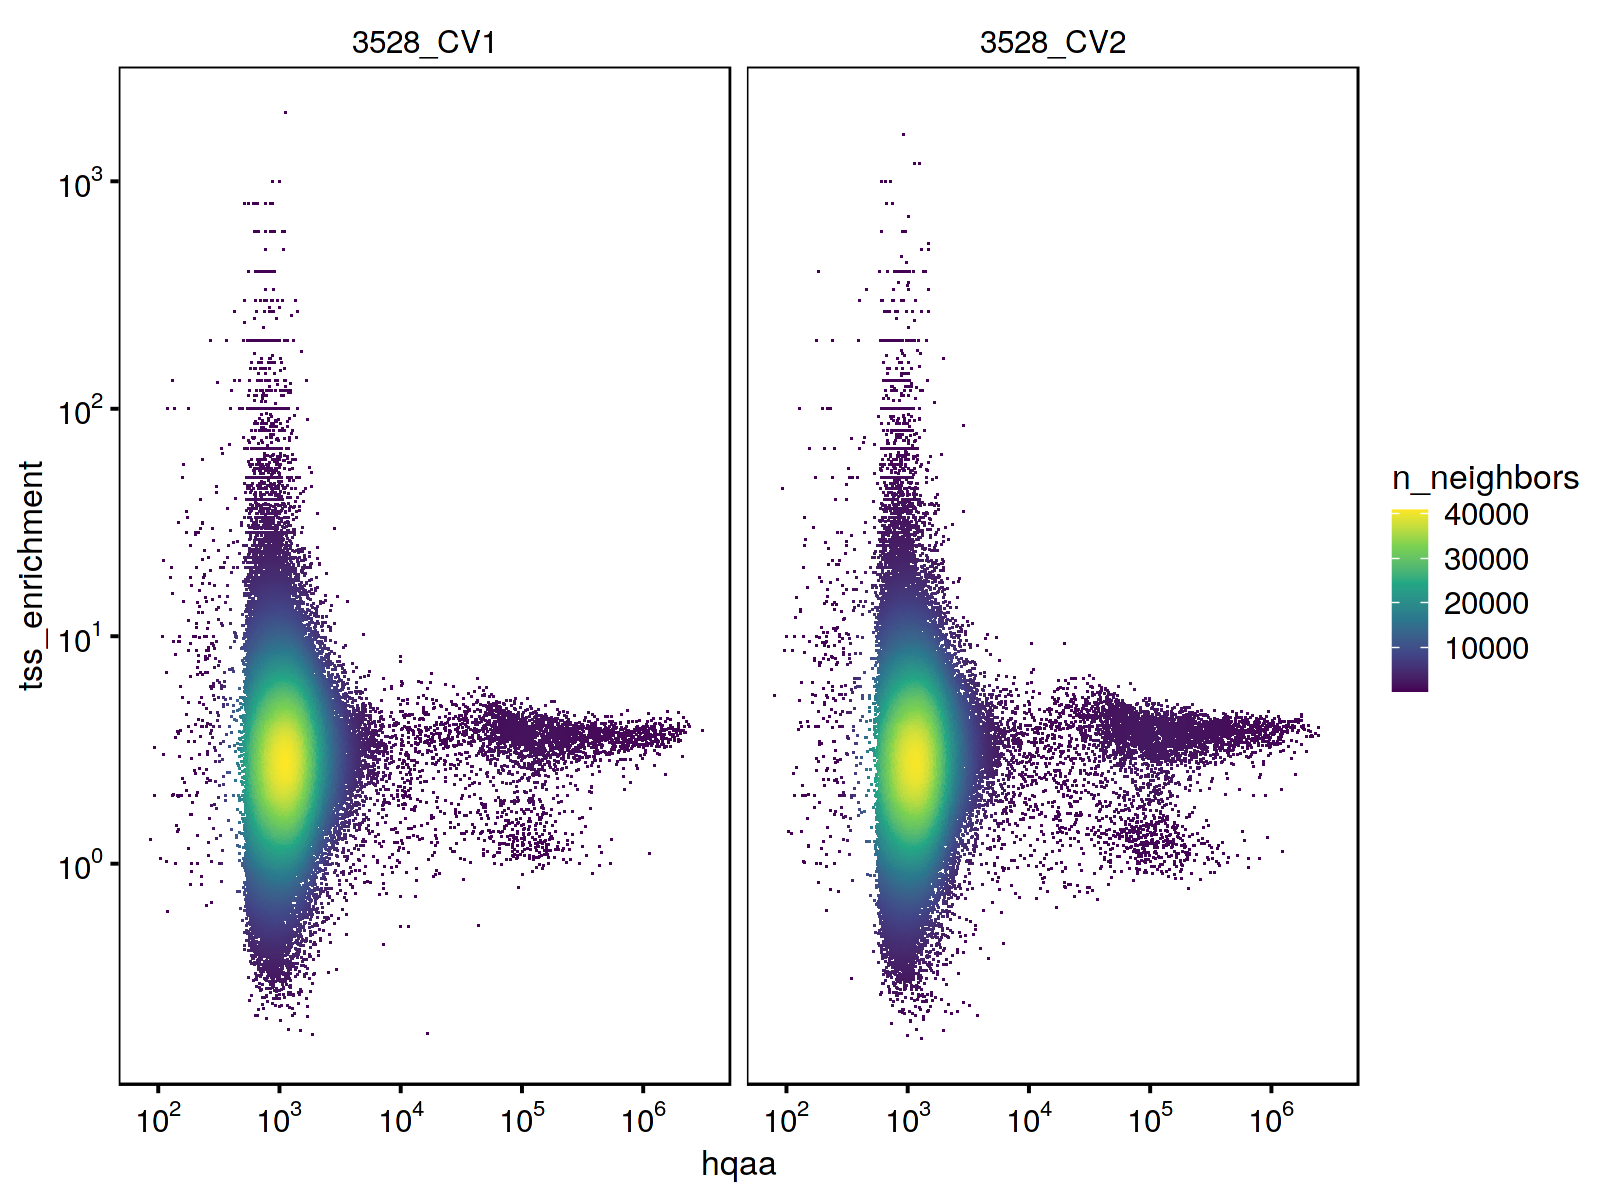

In [67]:
ggplot(atac_qc, aes(hqaa, tss_enrichment)) +
    geom_pointdensity(shape = '.') +
    scale_x_log10(labels = scales::trans_format("log10", scales::math_format(10^.x))) +
    scale_y_log10(labels = scales::trans_format("log10", scales::math_format(10^.x))) +
    facet_wrap(~ Sample)

Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 287 rows containing non-finite values (stat_pointdensity)."


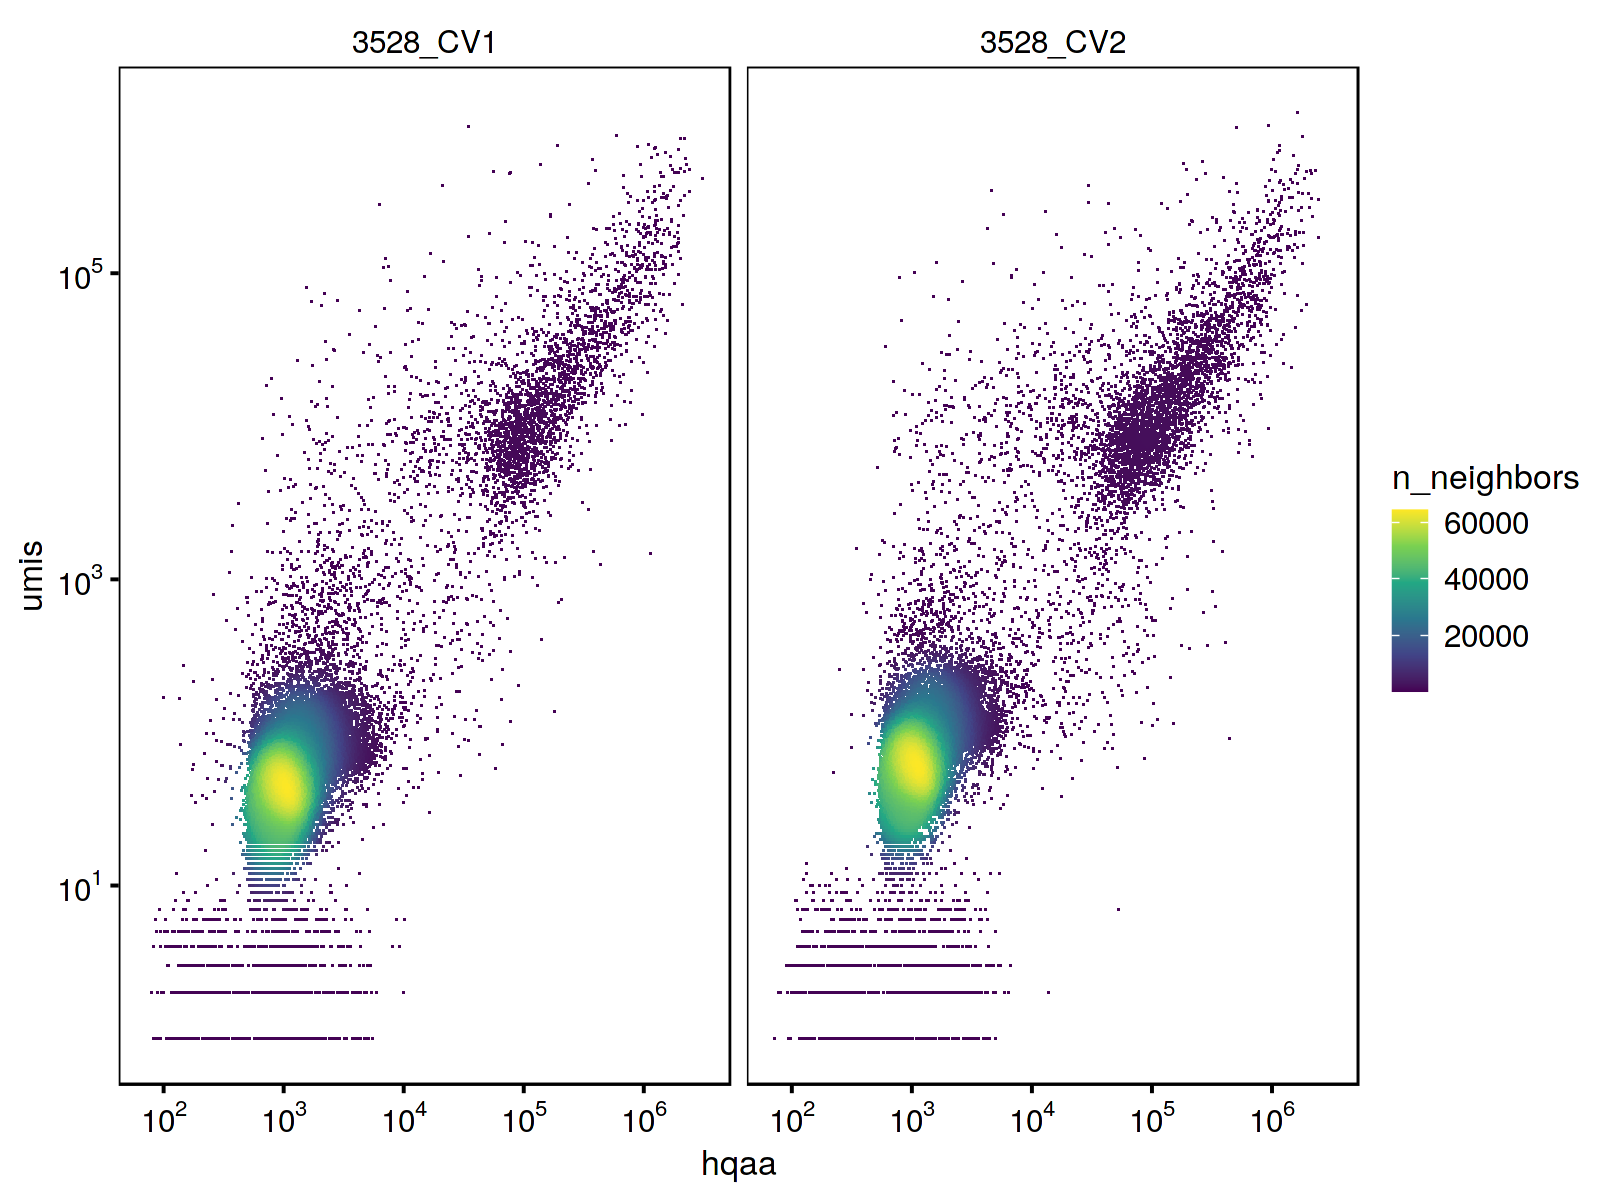

In [68]:
ggplot(comb_df, aes(hqaa, umis)) + geom_pointdensity(shape = '.') + 
    scale_x_log10(labels = scales::trans_format("log10", scales::math_format(10^.x))) +
    scale_y_log10(labels = scales::trans_format("log10", scales::math_format(10^.x))) +
    facet_wrap(~Sample)

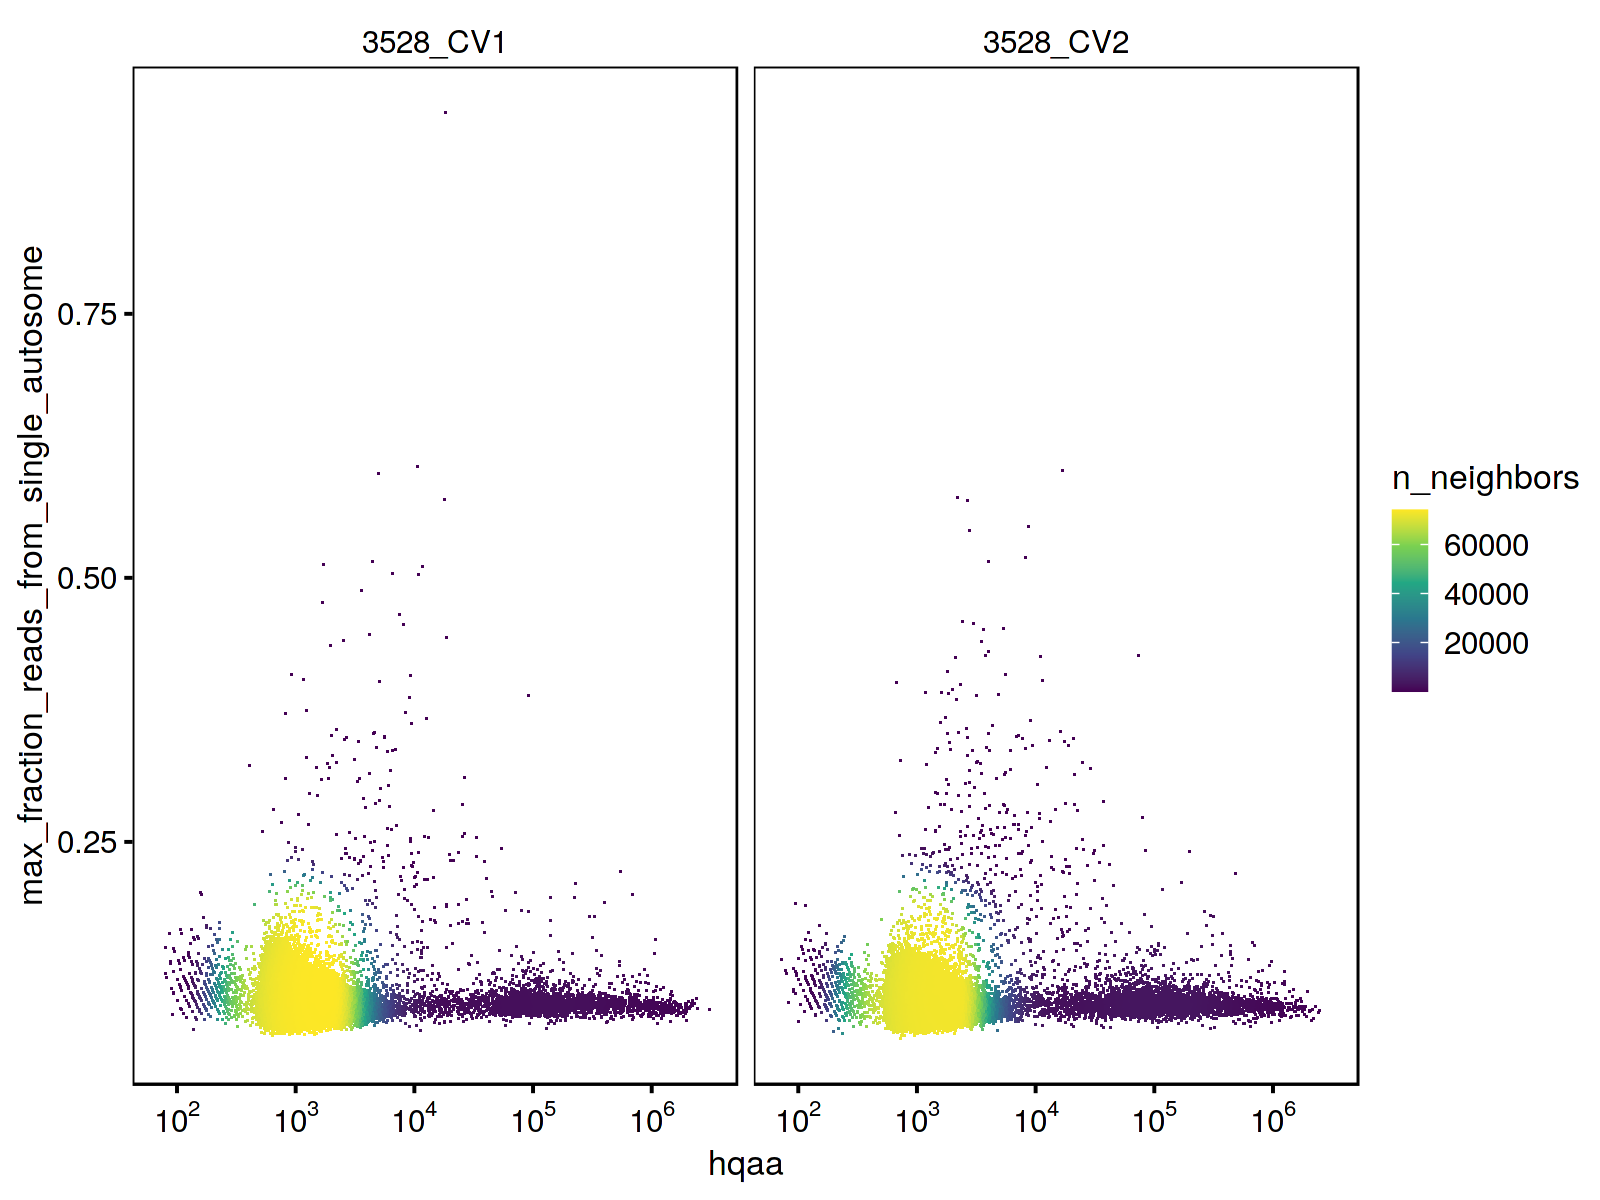

In [73]:
ggplot(comb_df, aes(hqaa, max_fraction_reads_from_single_autosome)) +
    scale_x_log10(labels = scales::trans_format("log10", scales::math_format(10^.x))) +
    geom_pointdensity(shape = '.') +
    facet_wrap(~Sample)

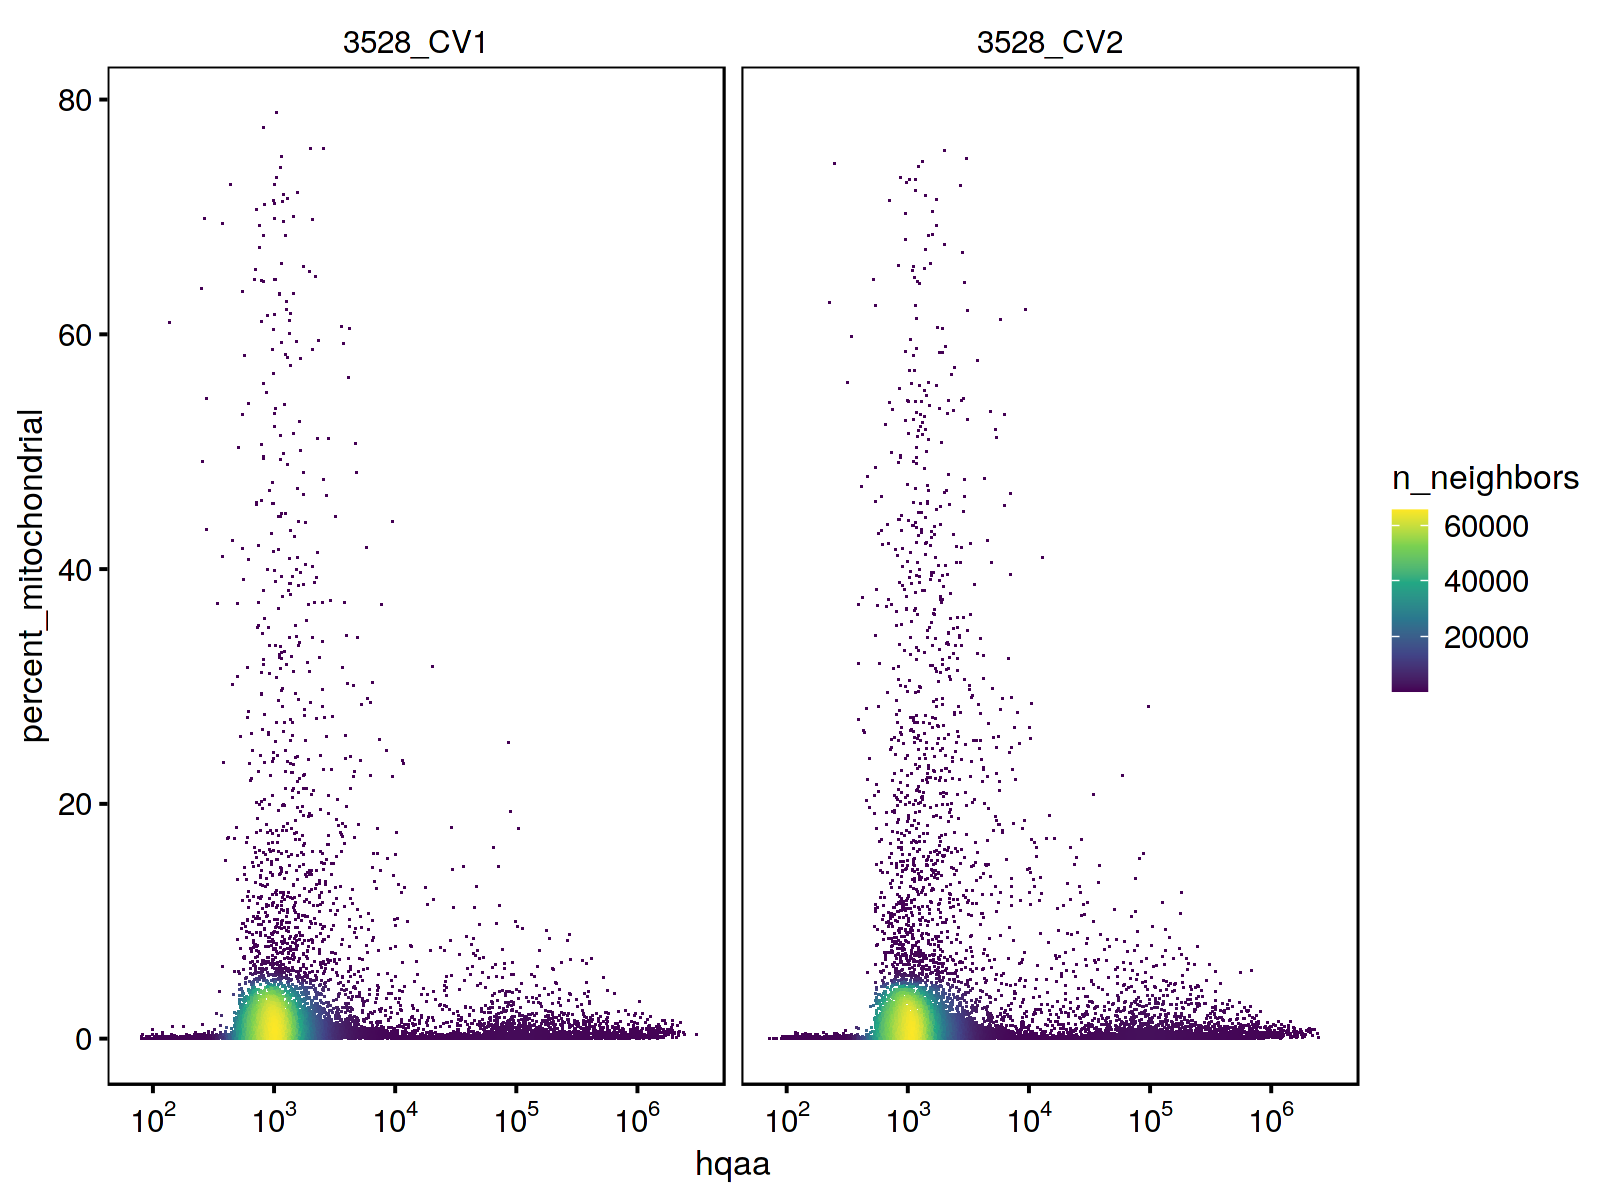

In [74]:
ggplot(comb_df, aes(hqaa, percent_mitochondrial)) +
    scale_x_log10(labels = scales::trans_format("log10", scales::math_format(10^.x))) +
    geom_pointdensity(shape = '.') +
    facet_wrap(~ Sample)

In [79]:
table(subset(comb_df, umis > 500 & hqaa > 5000 & tss_enrichment > 2, "Sample"))


3528_CV1 3528_CV2 
    2549     3637 

Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 5004 rows containing missing values (geom_point)."


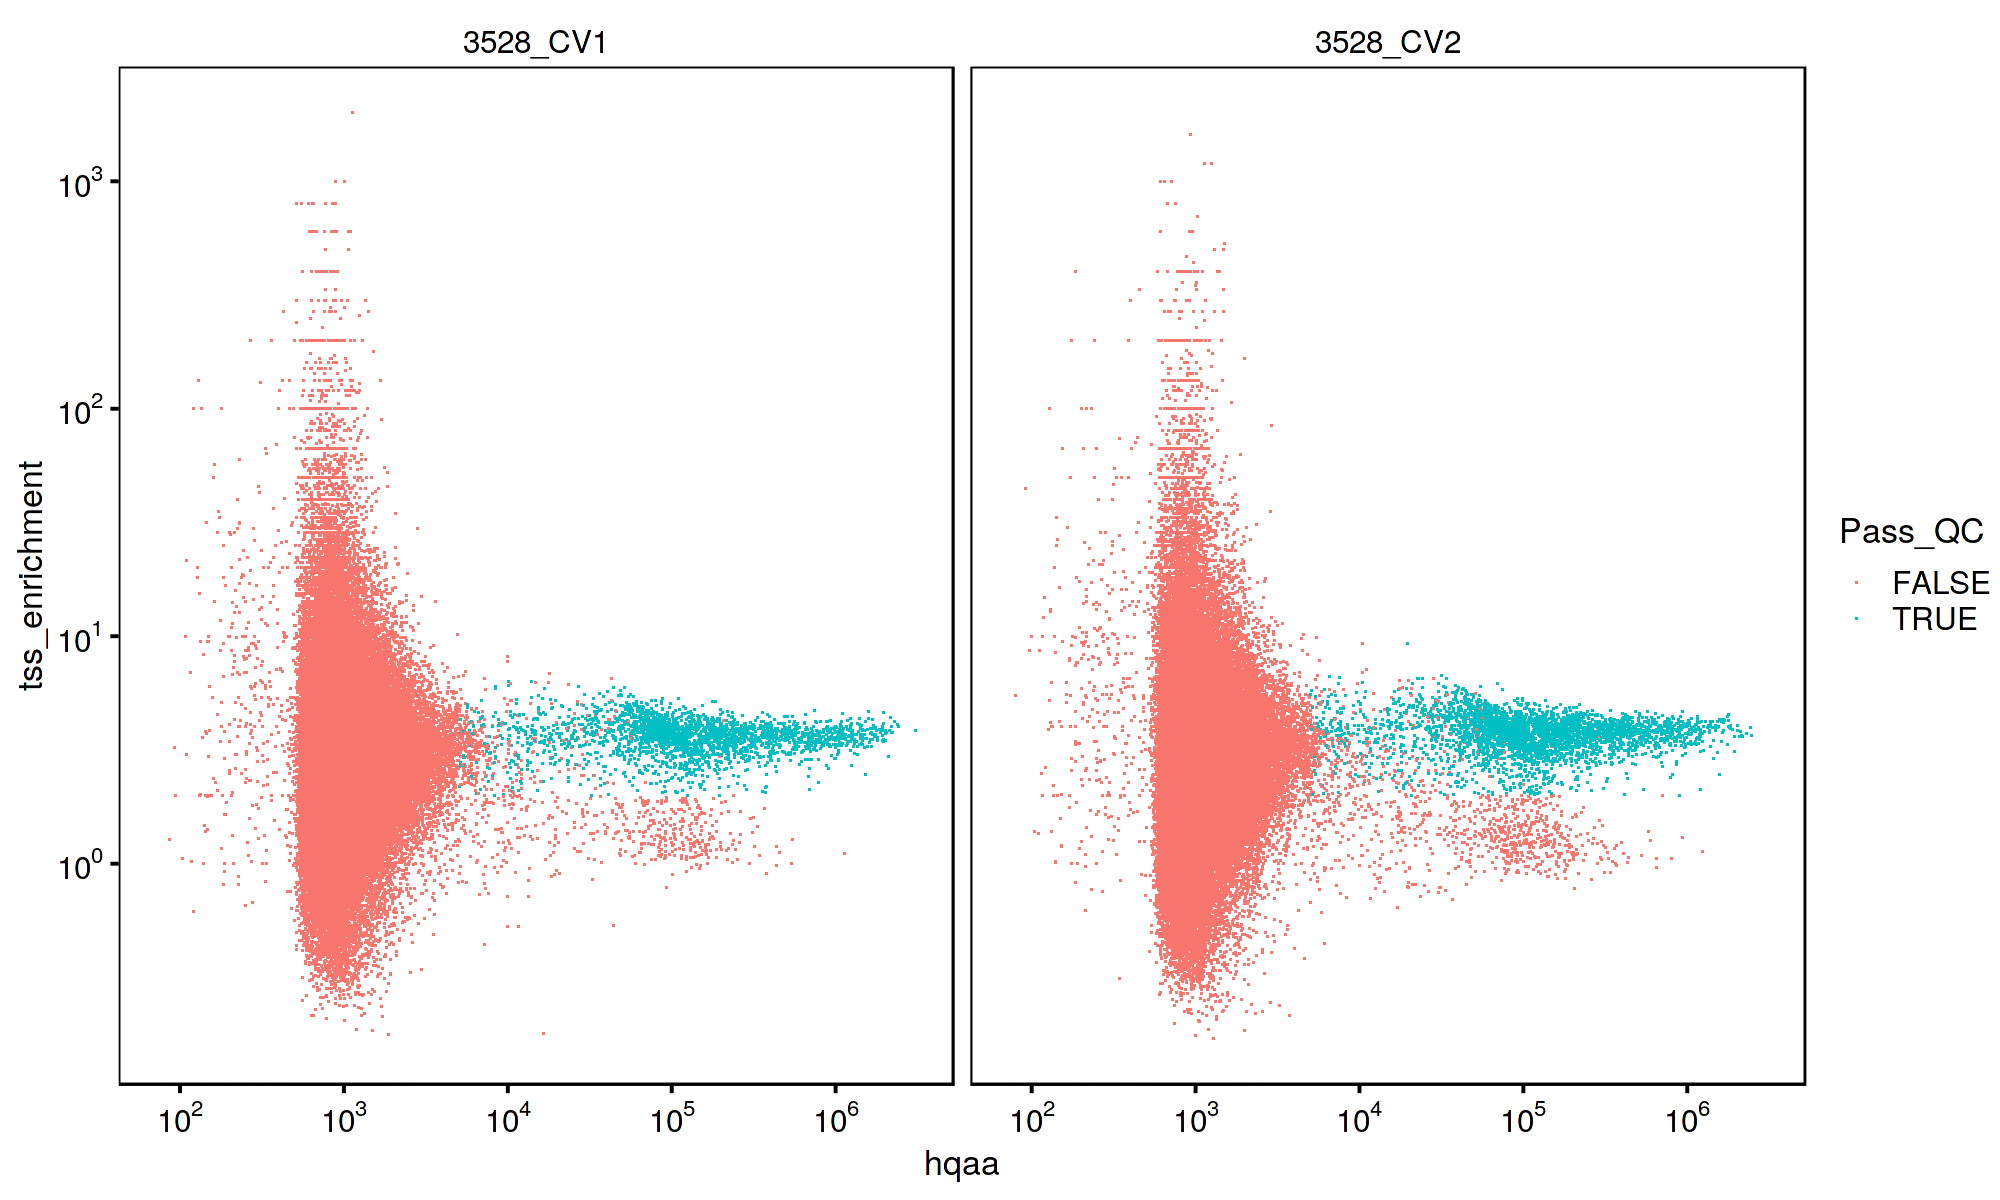

In [204]:
ggplot(demux_comb_df, aes(hqaa, tss_enrichment)) +
    scale_x_log10(labels = scales::trans_format("log10", scales::math_format(10^.x))) +
    scale_y_log10(labels = scales::trans_format("log10", scales::math_format(10^.x))) +
    geom_point(aes(col = Pass_QC), shape = '.') +
    facet_wrap(~ Sample)

Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 5004 rows containing missing values (geom_point)."


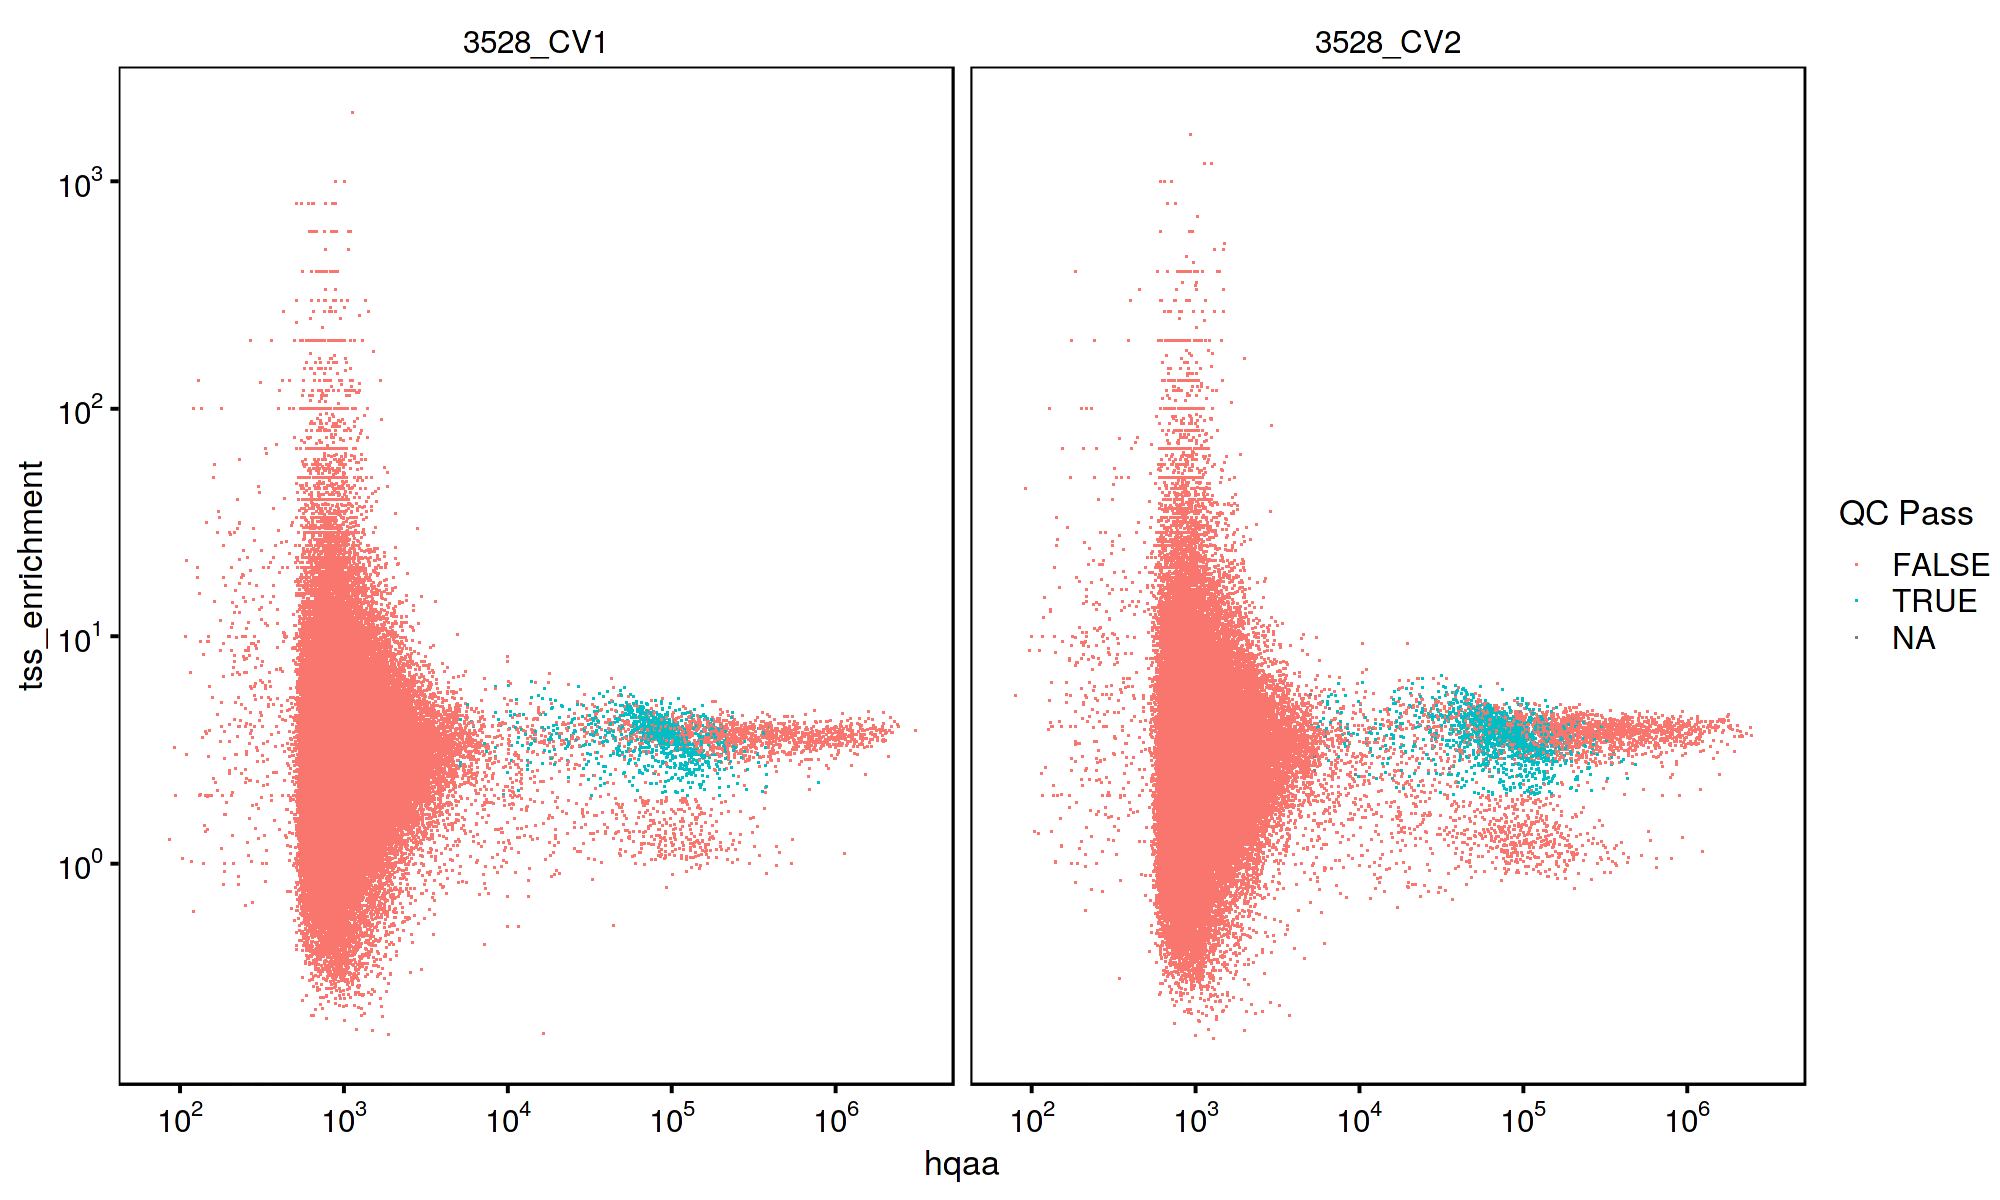

In [209]:
ggplot(demux_comb_df, aes(hqaa, tss_enrichment)) +
    scale_x_log10(labels = scales::trans_format("log10", scales::math_format(10^.x))) +
    scale_y_log10(labels = scales::trans_format("log10", scales::math_format(10^.x))) +
    geom_point(aes(col = Pass_QC & (Demux_both == "SNG")), shape = '.') +
    facet_wrap(~ Sample) +
    labs(col = "QC Pass")

## Demuxlet results

In [69]:
atac_demux <- lapply(atac_libs, function(x) {
    list.files(glue("{root}/work/demuxlet_atac/demuxlet"), glue("{x}.*.best"), full.names = T) %>%
    map(function(x) read.table(x, header = T)) %>%
    reduce(rbind) %>%
    dplyr::mutate(Sample = gsub("_ATAC", "", x))
}) %>% bind_rows() %>%
    dplyr::mutate(ATAC_Demux = stringr::str_split(BEST, "-", simplify = TRUE)[, 1]) %>%
    dplyr::select(BARCODE, RD.UNIQ, SNG.1ST, PRB.SNG1, Sample, ATAC_Demux) %>%
    dplyr::rename(ATAC_SNG.1ST = SNG.1ST, ATAC_PRB.SNG1 = PRB.SNG1)

In [38]:
head(atac_demux)

,BARCODE,RD.UNIQ,BEST,SNG.1ST,PRB.SNG1,Sample,out
,<chr>,<int>,<chr>,<chr>,<dbl>,<chr>,<chr>
1,AAACCAGGTATTGAGG,16534,DBL-3_16550021-ND-50yF-SC-5_AHKI007-HPAP074-0.500,5_AHKI007-HPAP074,NaN,3528_ATAC_CV1,DBL
2,AAACCGGTCGACATTT,22830,SNG-5_AHKI007-HPAP074,5_AHKI007-HPAP074,1,3528_ATAC_CV1,SNG
3,AAACGAACAGGTTATG,12841,SNG-1_16191825-ND-25yM-SC,1_16191825-ND-25yM-SC,1,3528_ATAC_CV1,SNG
4,AAACGGTTCGAAGTAC,85727,DBL-1_16191825-ND-25yM-SC-2_16515959-ND-51yF-SC-0.500,1_16191825-ND-25yM-SC,NaN,3528_ATAC_CV1,DBL
5,AAACTAGTCTCAGCTA,8199,SNG-3_16550021-ND-50yF-SC,3_16550021-ND-50yF-SC,1,3528_ATAC_CV1,SNG
6,AAACTCGCATTCCTGG,5031,SNG-1_16191825-ND-25yM-SC,1_16191825-ND-25yM-SC,1,3528_ATAC_CV1,SNG


In [70]:
rna_demux <- lapply(c("3528_CV1", "3528_CV2"), function(x) {
    list.files(glue("{root}/work/demuxlet_rna/demuxlet"), glue("{x}.*.best"), full.names = T) %>%
    map(function(x) read.table(x, header = T)) %>%
    reduce(rbind) %>%
    dplyr::mutate(Sample = x)
}) %>% bind_rows() %>%
    dplyr::mutate(RNA_Demux = stringr::str_split(BEST, "-", simplify = TRUE)[, 1]) %>%
    dplyr::select(BARCODE, SNG.1ST, PRB.SNG1, Sample, RNA_Demux) %>%
    dplyr::rename(RNA_SNG.1ST = SNG.1ST, RNA_PRB.SNG1 = PRB.SNG1)

In [71]:
head(rna_demux)

,BARCODE,RNA_SNG.1ST,RNA_PRB.SNG1,Sample,RNA_Demux
,<chr>,<chr>,<dbl>,<chr>,<chr>
1,AAACCGCGTCTTTATG,1_16191825-ND-25yM-SC,1,3528_CV1,SNG
2,AAACCGCGTGCGCAAT,2_16515959-ND-51yF-SC,1,3528_CV1,SNG
3,AAACGCGCACTTACAG,1_16191825-ND-25yM-SC,NaN,3528_CV1,DBL
4,AAACGTACATTCCTCG,1_16191825-ND-25yM-SC,NaN,3528_CV1,DBL
5,AAAGCCCGTCAGGCAT,1_16191825-ND-25yM-SC,NaN,3528_CV1,DBL
6,AAAGCCCGTTTCCACG,2_16515959-ND-51yF-SC,1,3528_CV1,SNG


In [73]:
demux_comb_df <- comb_df %>%
    left_join(atac_demux, by = c("Barcode" = "BARCODE", "Sample")) %>%
    left_join(rna_demux, by = c("rna_barcode" = "BARCODE", "Sample"))

In [169]:
demux_comb_df <- demux_comb_df %>%
    mutate(Demux_both = ifelse(ATAC_Demux == RNA_Demux, ATAC_Demux, ifelse(ATAC_Demux == "SNG", "ATAC-SNG/RNA-DBL", "ATAC-DBL/RNA-SNG")))

In [183]:
dim(demux_comb_df)
head(demux_comb_df)

[1] 155614     27

Sample,Barcode,tss_enrichment,percent_hqaa,hqaa,total_reads.x,total_autosomal_reads,percent_mitochondrial,percent_autosomal_duplicate,percent_duplicate,⋯,fraction_mitochondrial,RD.UNIQ,ATAC_SNG.1ST,ATAC_PRB.SNG1,ATAC_Demux,RNA_SNG.1ST,RNA_PRB.SNG1,RNA_Demux,Pass_QC,Demux_both
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<int>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<lgl>,<chr>
3528_CV1,AAACAAGCAAACATGT,2.713178,56.95306,1286,2258,1902,0.17714792,30.178759,27.05934,⋯,0.04819277,NA,NA,NA,NA,NA,NA,NA,FALSE,NA
3528_CV1,AAACAAGCAAACCCAA,1.293103,53.50488,1206,2254,1760,1.86335404,29.204545,26.30878,⋯,0.08928571,NA,NA,NA,NA,NA,NA,NA,FALSE,NA
3528_CV1,AAACAAGCAAAGAAGC,6.493506,10.13128,1173,11578,1671,0.03454828,2.692998,1.00190,⋯,0.00000000,NA,NA,NA,NA,NA,NA,NA,FALSE,NA
3528_CV1,AAACAAGCAAATGAAG,2.094241,47.98729,906,1888,1440,0.42372881,35.138889,28.60169,⋯,0.00000000,NA,NA,NA,NA,NA,NA,NA,FALSE,NA
3528_CV1,AAACAAGCAACAACAT,2.474227,53.64078,1768,3296,2585,0.24271845,28.974855,25.06068,⋯,0.07792208,NA,NA,NA,NA,NA,NA,NA,FALSE,NA
3528_CV1,AAACAAGCAACATAGT,1.900739,54.13682,3023,5584,4482,0.35816619,29.339581,26.14613,⋯,0.05238095,NA,NA,NA,NA,NA,NA,NA,FALSE,NA


Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 5004 rows containing missing values (geom_point)."


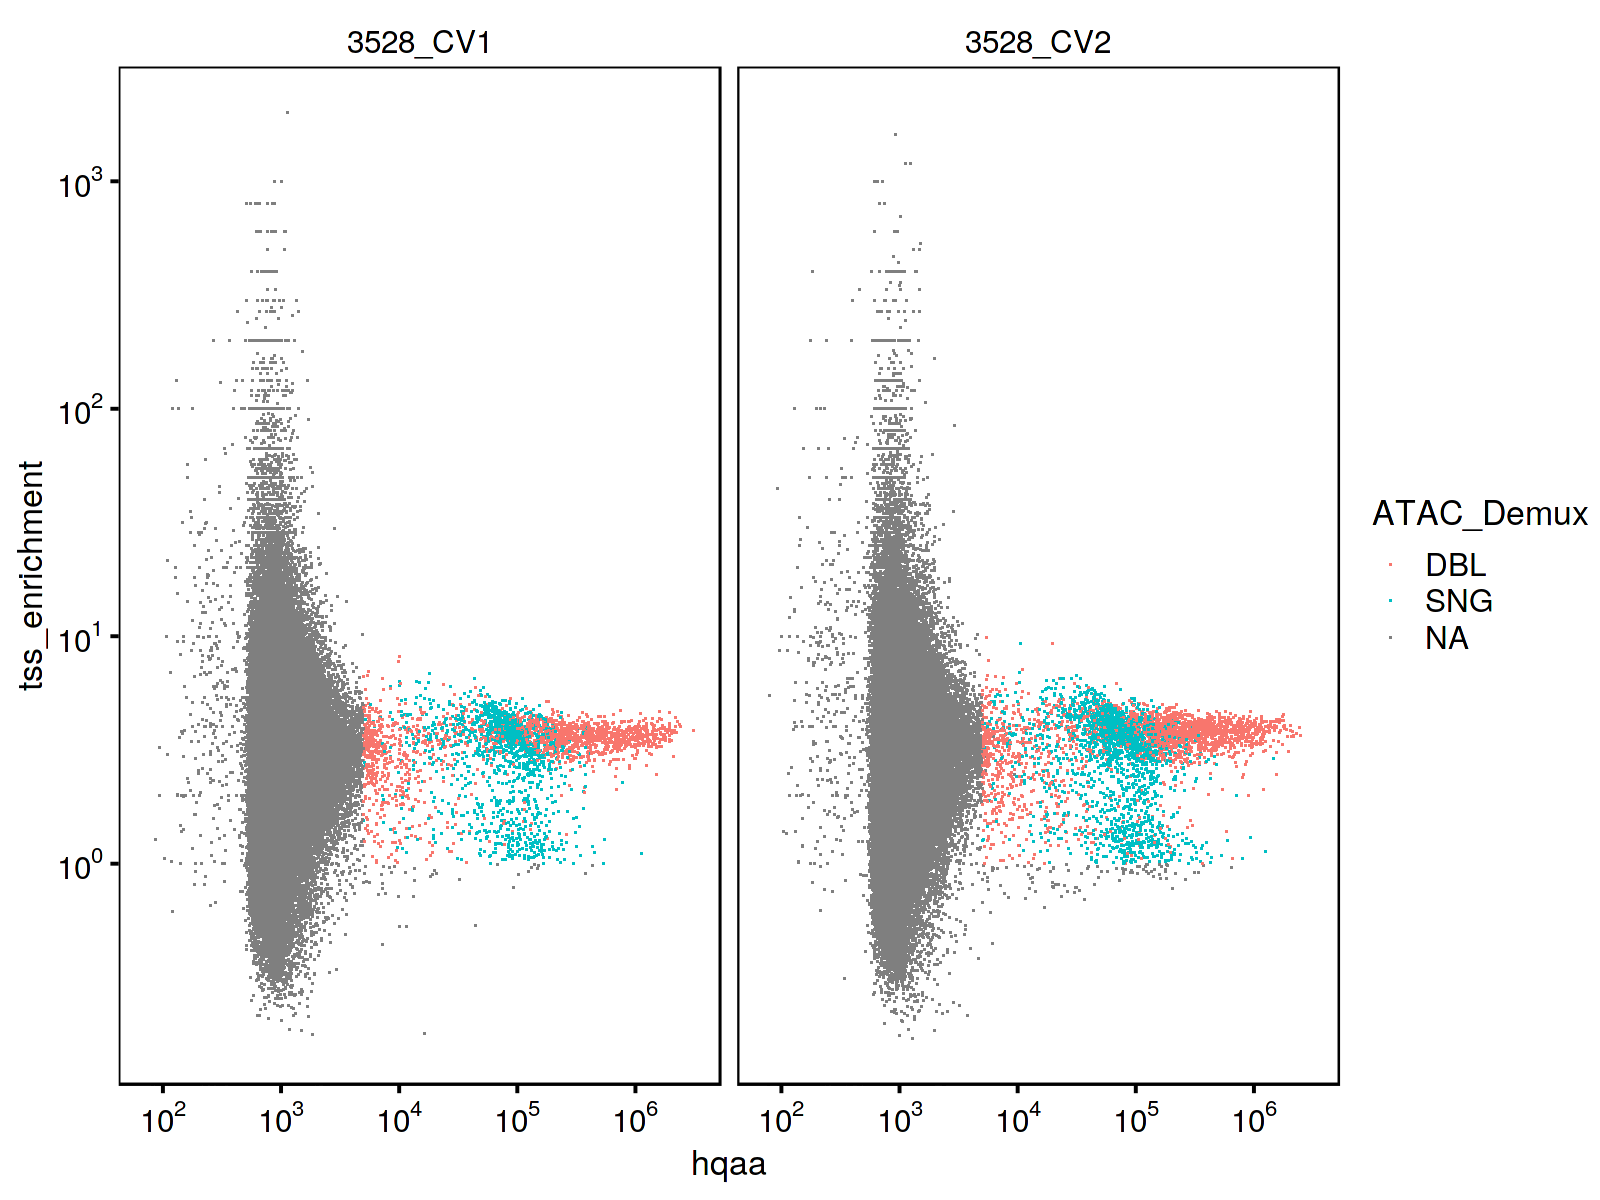

In [60]:
ggplot(demux_comb_df, aes(hqaa, tss_enrichment)) +
    geom_point(aes(col = ATAC_Demux), shape = '.') +
    scale_x_log10(labels = scales::trans_format("log10", scales::math_format(10^.x))) +
    scale_y_log10(labels = scales::trans_format("log10", scales::math_format(10^.x))) +
    facet_wrap(~ Sample)

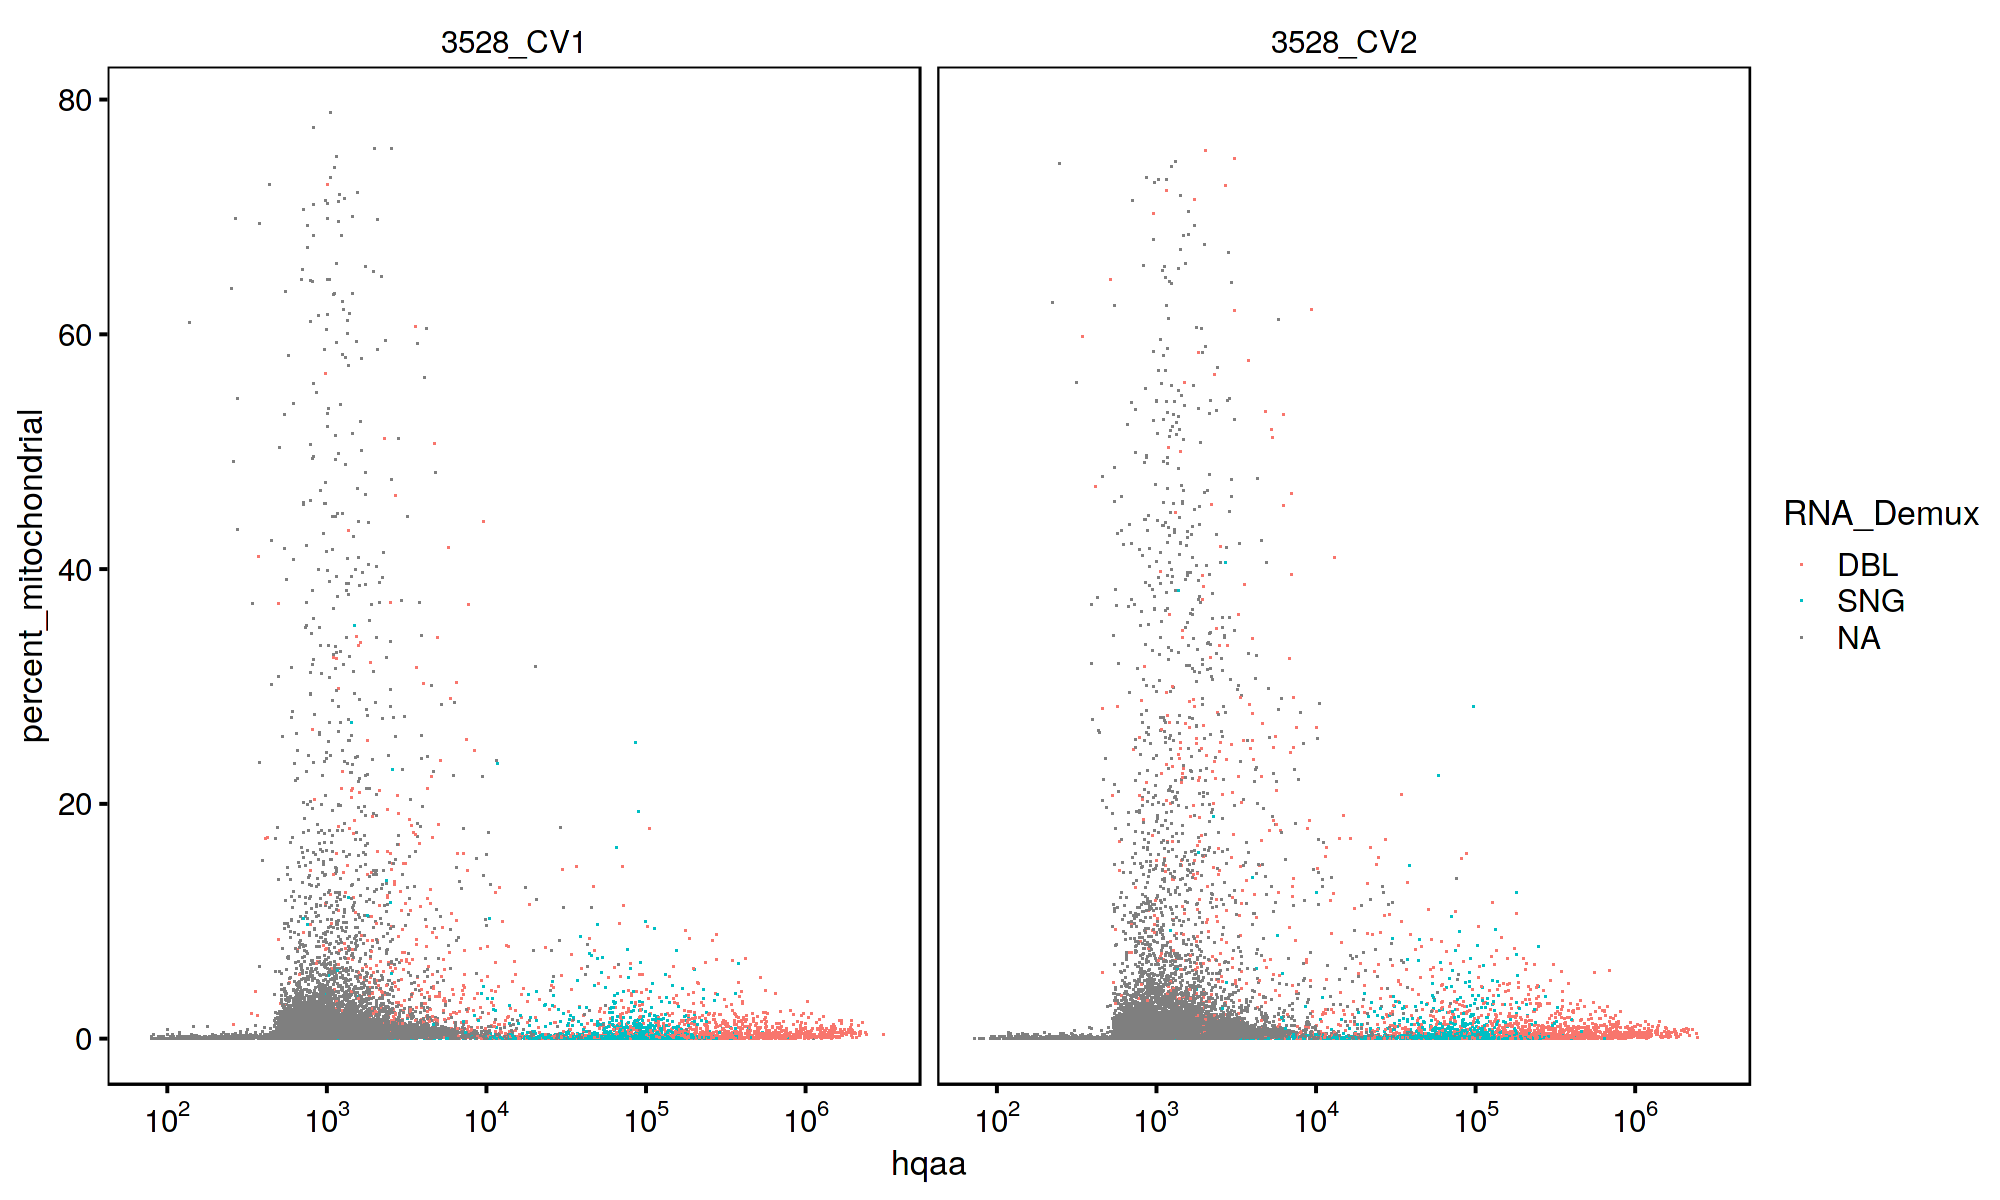

In [184]:
ggplot(demux_comb_df, aes(umis, percent_mitochondrial)) +
    geom_point(aes(col = RNA_Demux), shape = '.') +
    scale_x_log10(labels = scales::trans_format("log10", scales::math_format(10^.x))) +
    #scale_y_log10(labels = scales::trans_format("log10", scales::math_format(10^.x))) +
    facet_wrap(~ Sample)

Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 112 rows containing missing values (geom_point)."


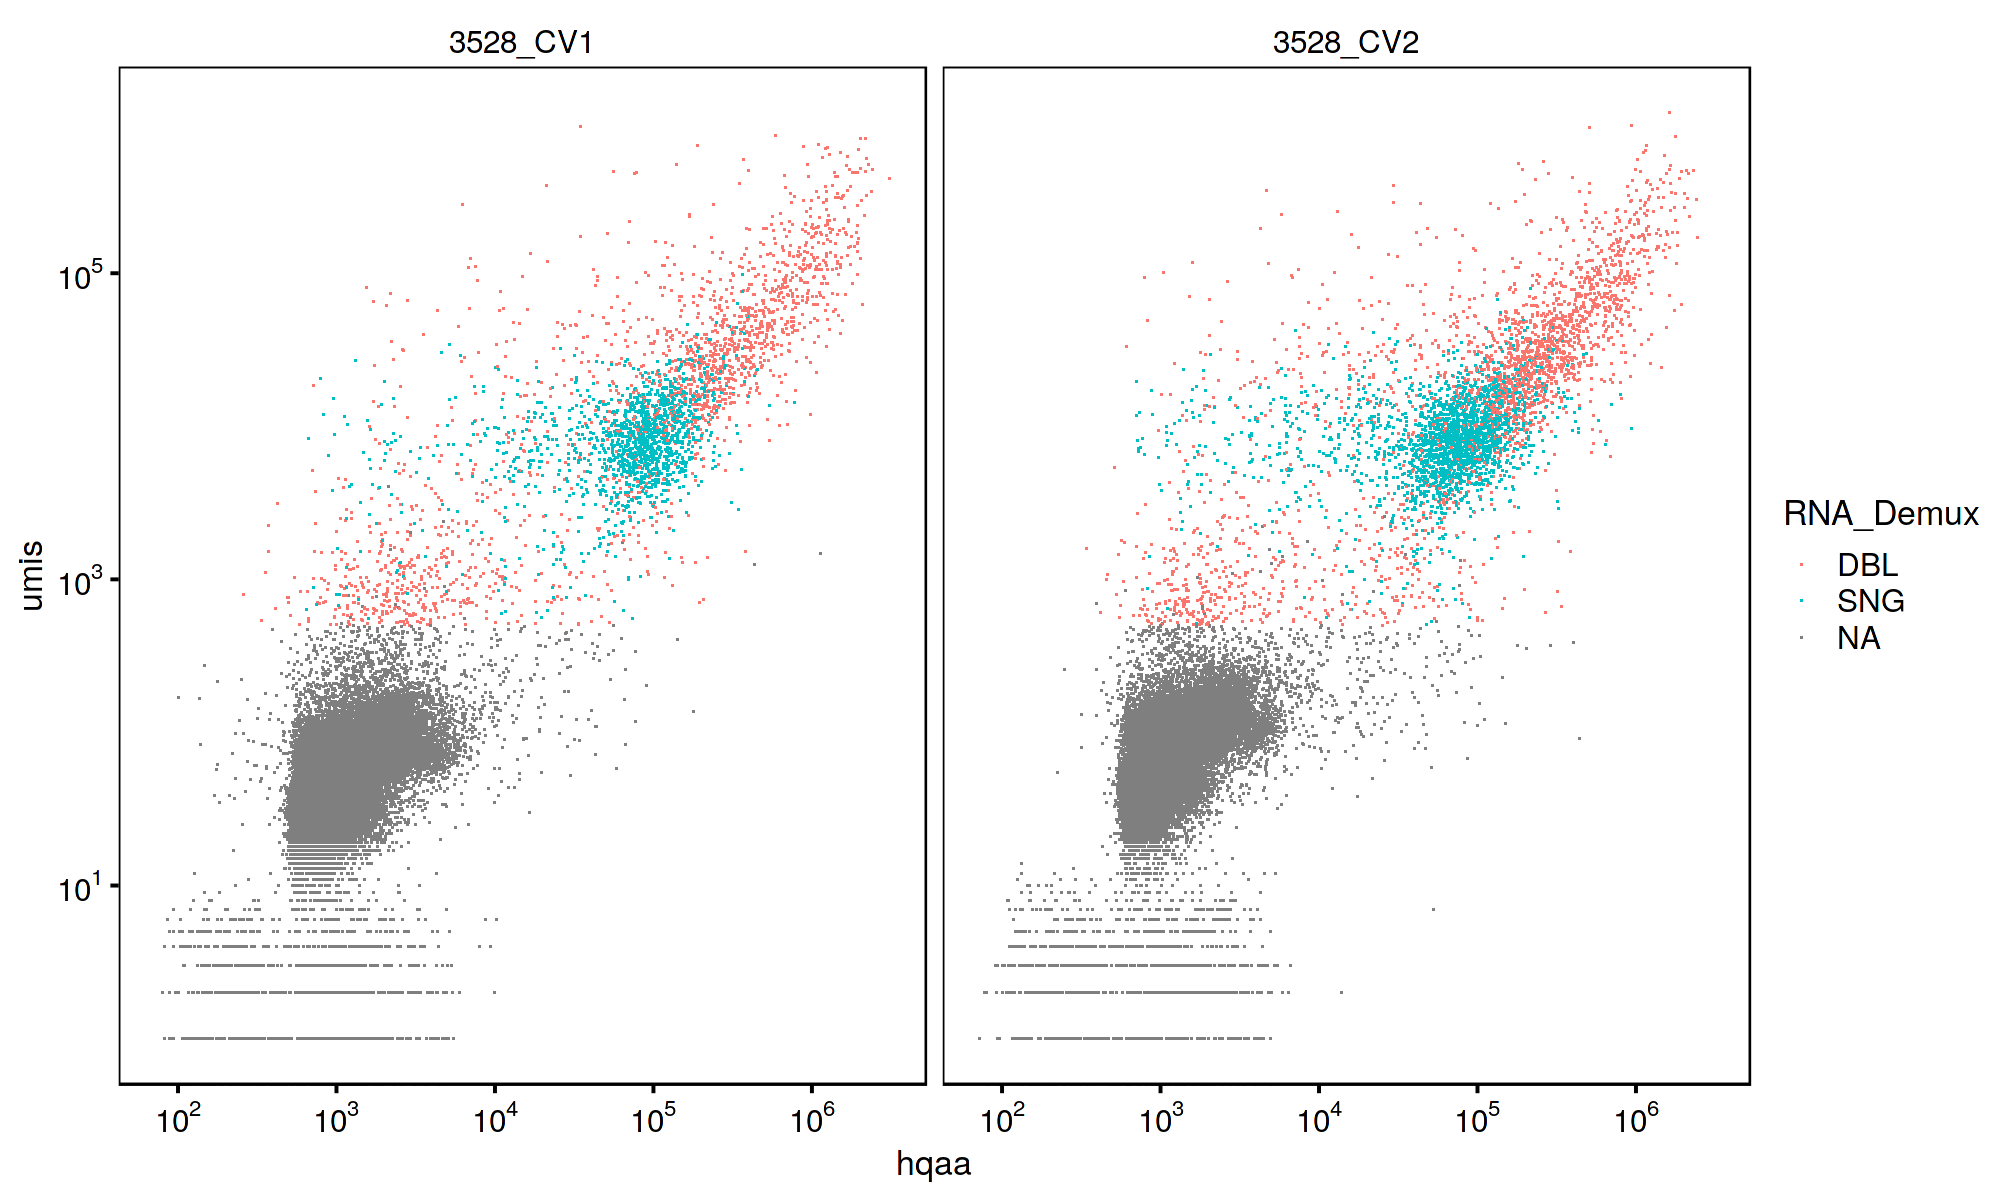

In [185]:
ggplot(demux_comb_df, aes(hqaa, umis)) +
    geom_point(aes(col = RNA_Demux), shape = '.') +
    scale_x_log10(labels = scales::trans_format("log10", scales::math_format(10^.x))) +
    scale_y_log10(labels = scales::trans_format("log10", scales::math_format(10^.x))) +
    facet_wrap(~ Sample)

Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 112 rows containing missing values (geom_point)."


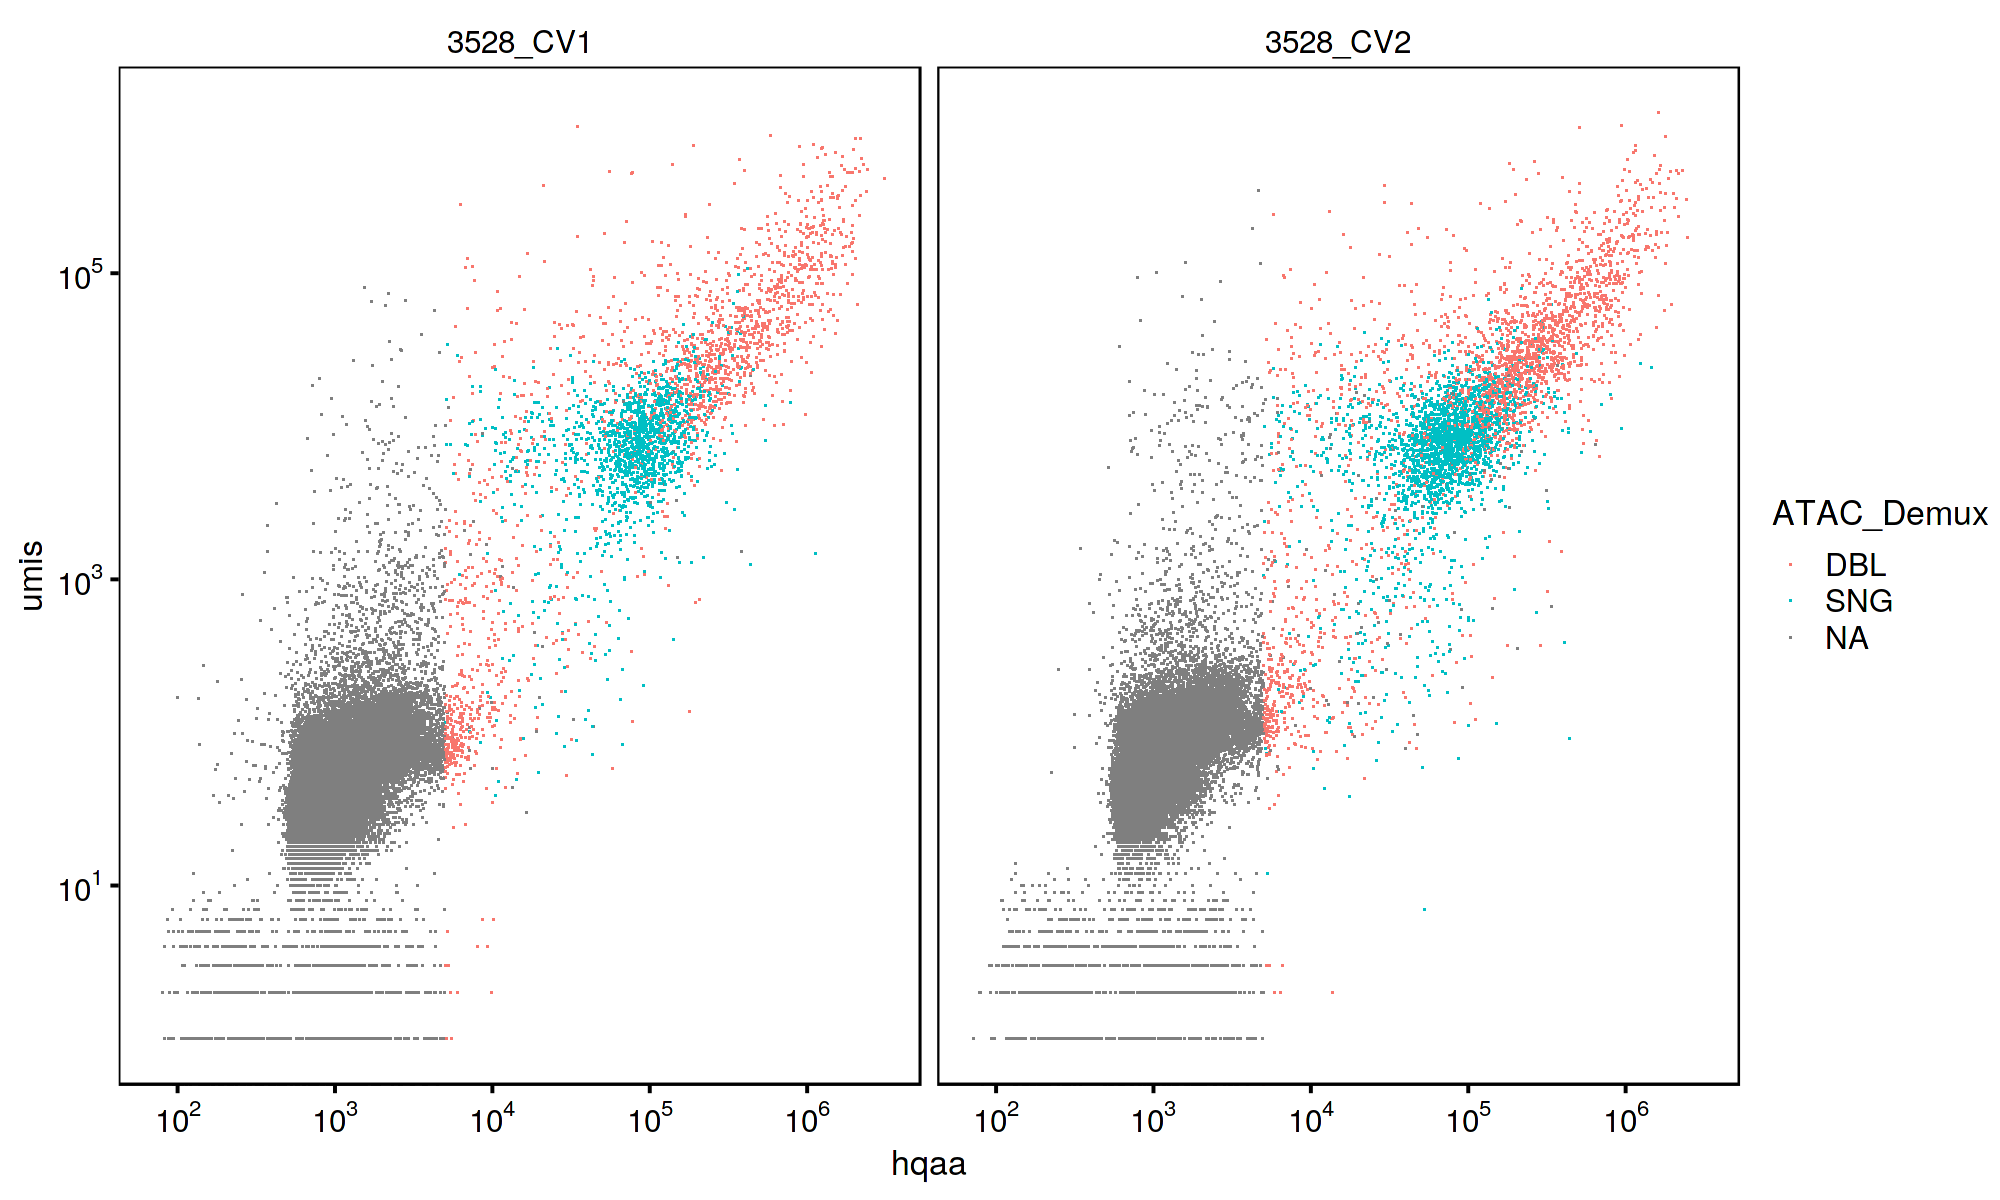

In [186]:
ggplot(demux_comb_df, aes(hqaa, umis)) +
    geom_point(aes(col = ATAC_Demux), shape = '.') +
    scale_x_log10(labels = scales::trans_format("log10", scales::math_format(10^.x))) +
    scale_y_log10(labels = scales::trans_format("log10", scales::math_format(10^.x))) +
    facet_wrap(~ Sample)

Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 18210 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 18210 rows containing missing values (geom_point)."


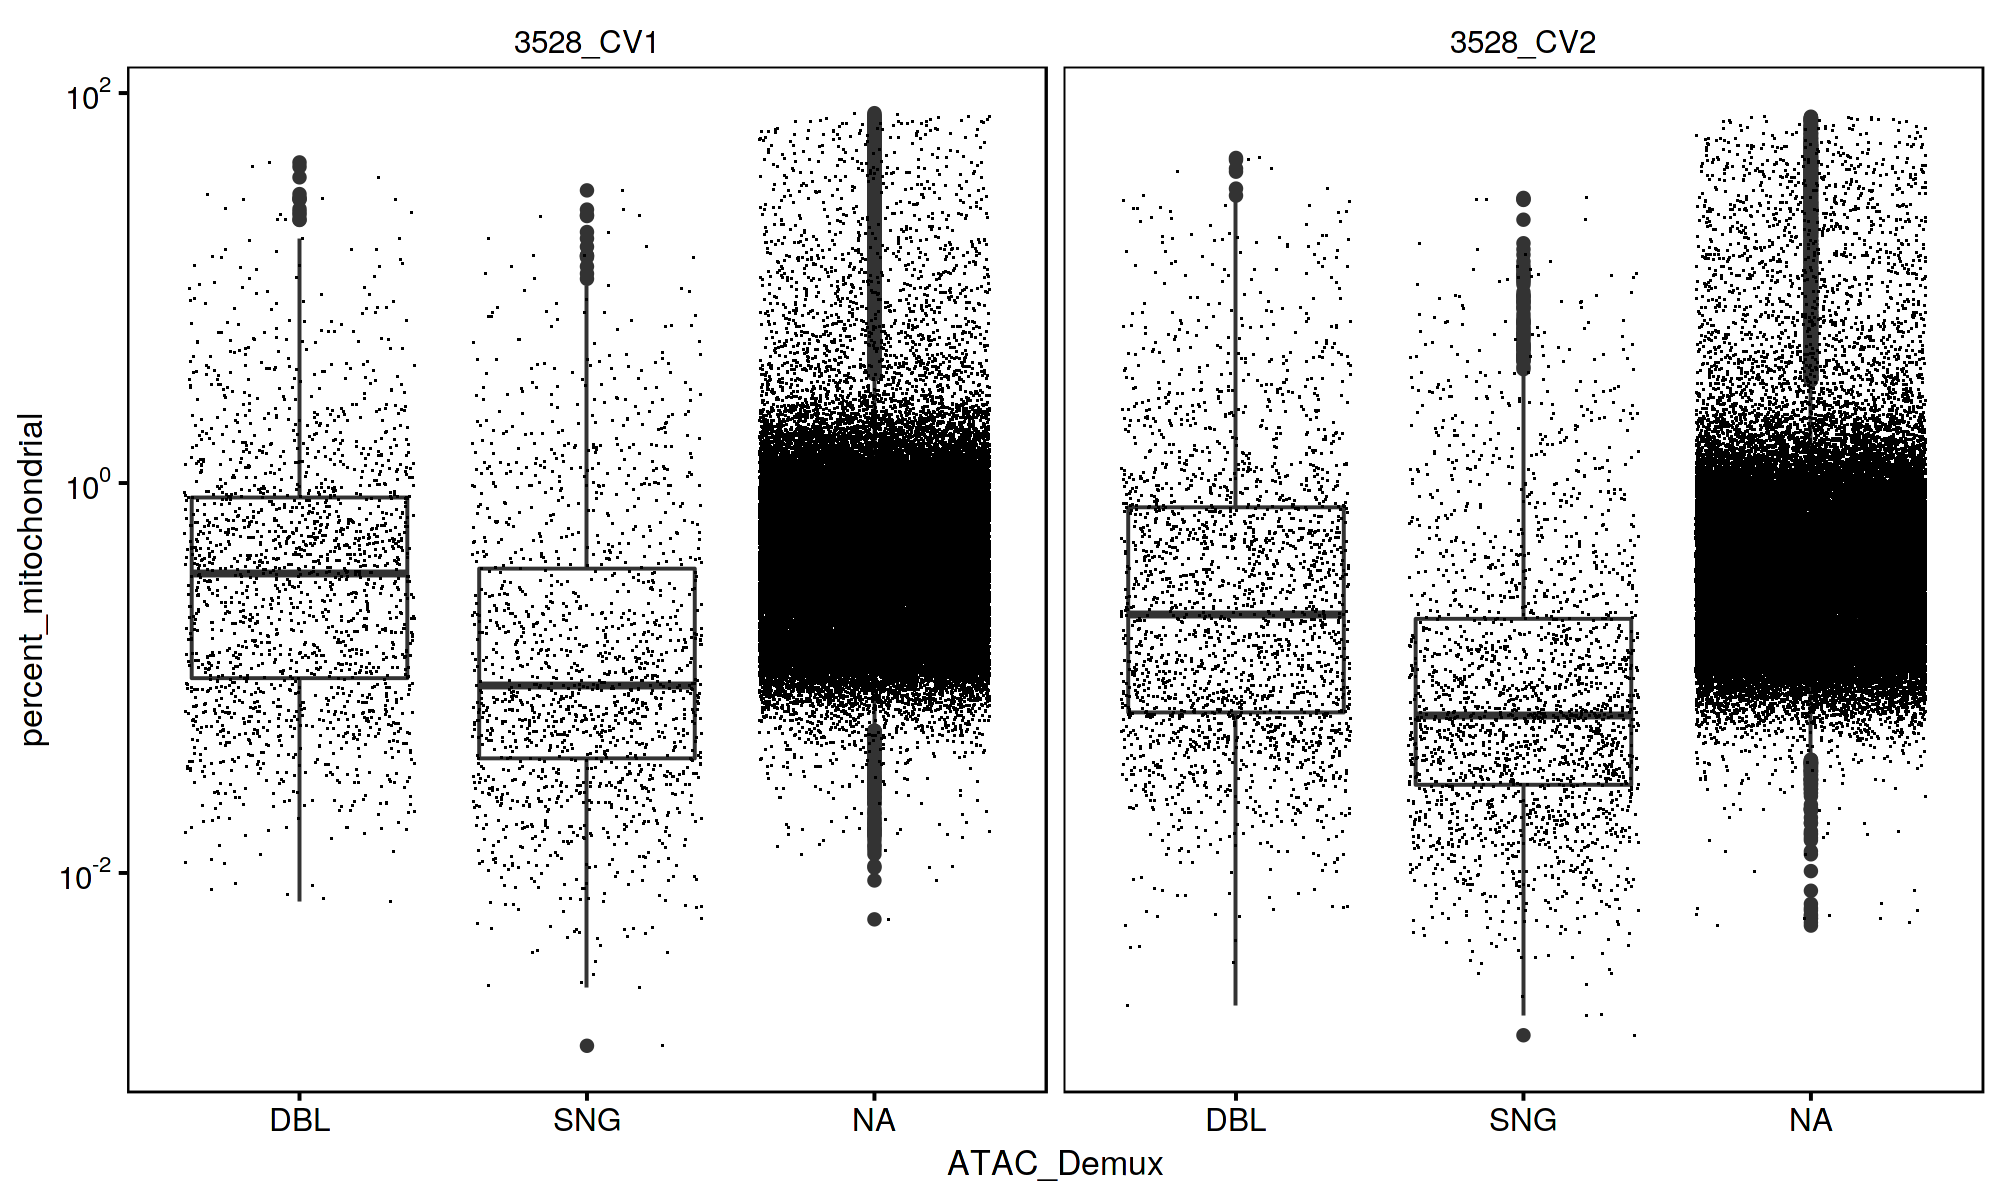

In [158]:
ggplot(demux_comb_df, aes(ATAC_Demux, percent_mitochondrial)) + 
    geom_boxplot() + geom_jitter(shape = '.') +
    facet_wrap(~Sample) +
    scale_y_log10(labels = scales::trans_format("log10", scales::math_format(10^.x))) 

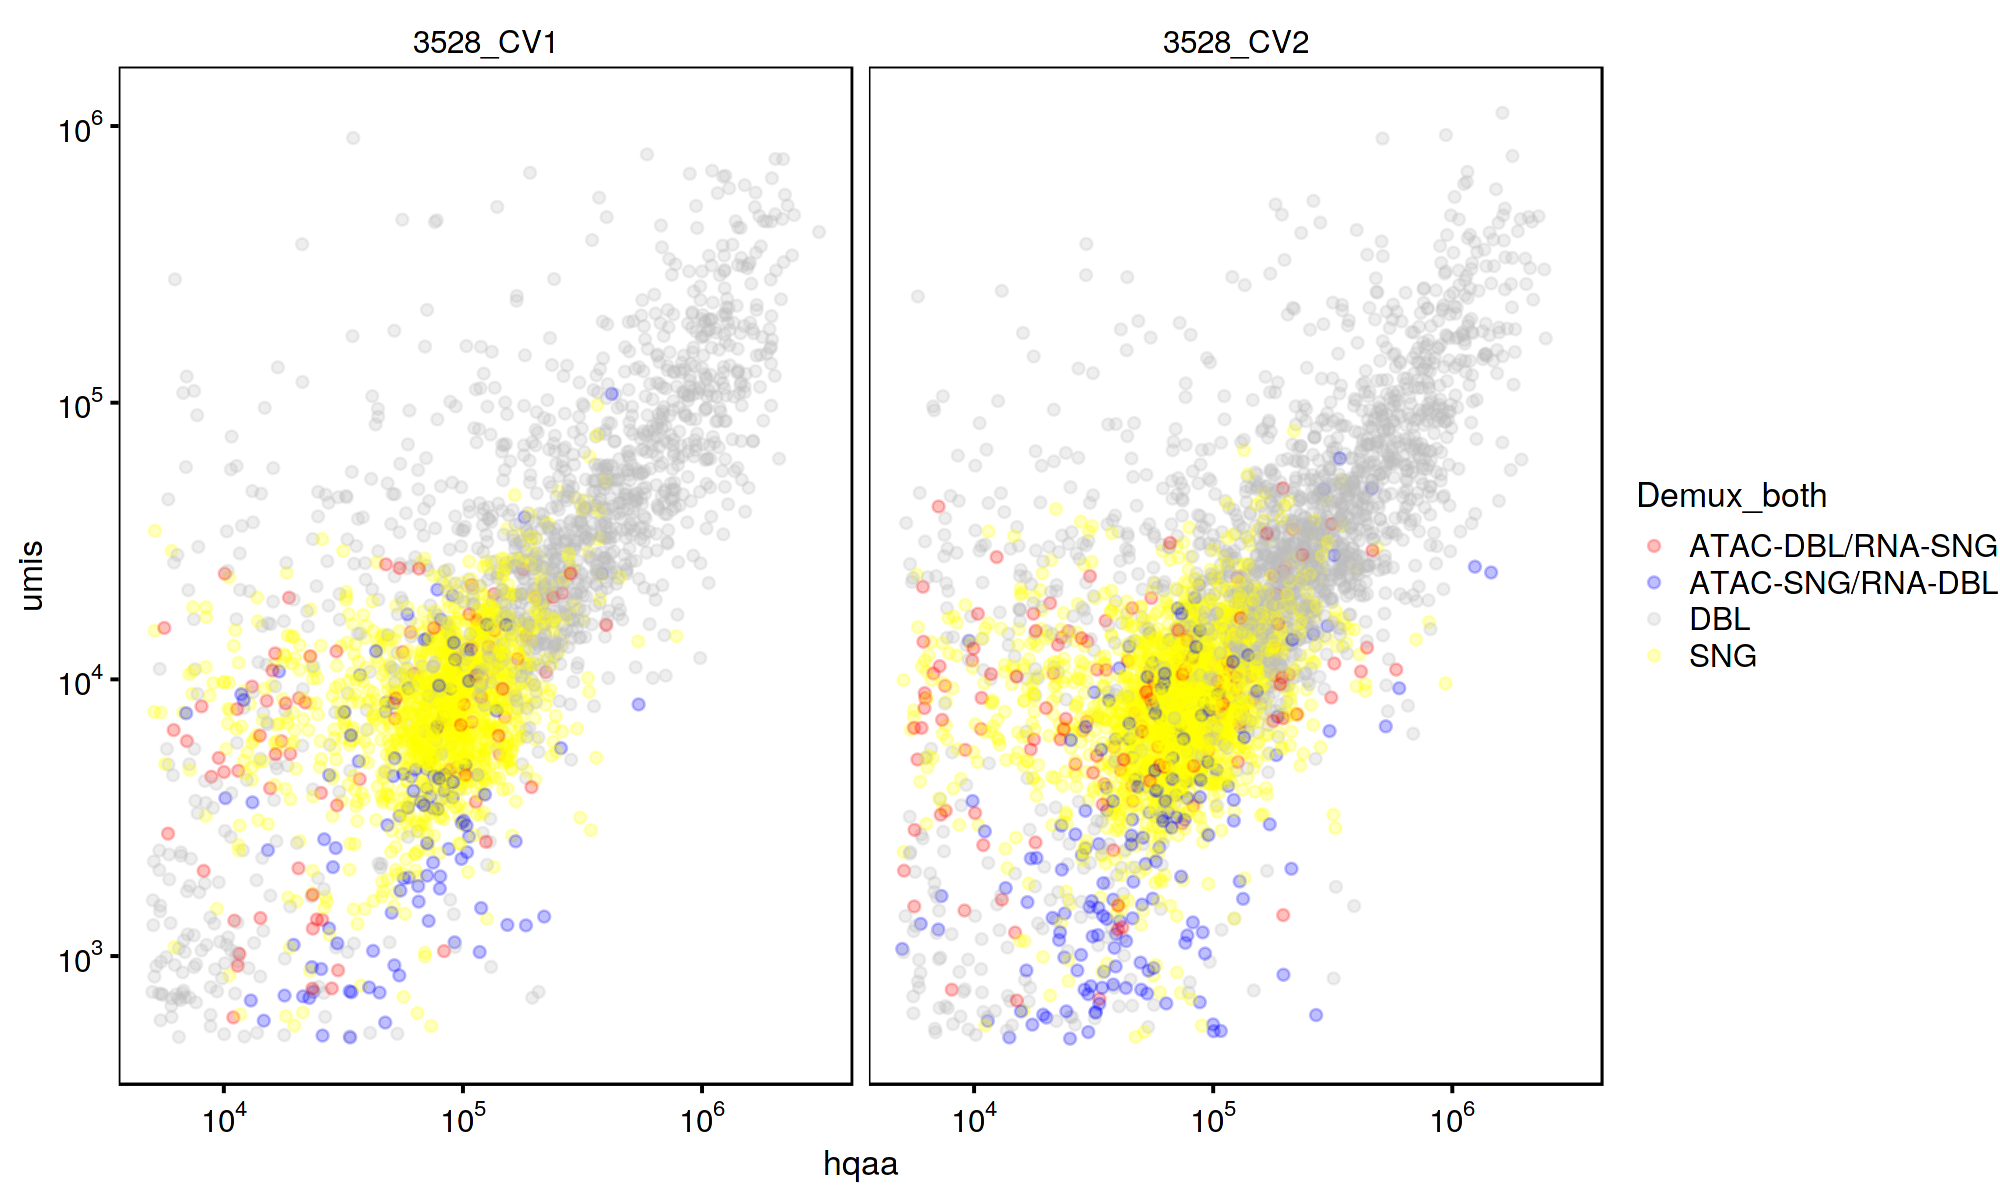

In [187]:
ggplot(demux_comb_df %>% filter(!is.na(Demux_both)), aes(hqaa, umis)) +
    geom_point(aes(col = Demux_both), alpha = .25) +
    scale_x_log10(labels = scales::trans_format("log10", scales::math_format(10^.x))) +
    scale_y_log10(labels = scales::trans_format("log10", scales::math_format(10^.x))) +
    scale_color_manual(values = c("red", "blue", "gray", "yellow")) +
    facet_wrap(~ Sample)

In [181]:
demux_comb_df$Pass_QC <- (demux_comb_df$hqaa >= 5000 & demux_comb_df$tss_enrichment >= 2 & demux_comb_df$umis >= 1000)

In [143]:
table(subset(demux_comb_df, Pass_QC)$ATAC_Demux, subset(demux_comb_df, Pass_QC)$Sample)

     
      3528_CV1 3528_CV2
  DBL     1378     1913
  SNG     1171     1720

In [144]:
table(subset(demux_comb_df, Pass_QC)$RNA_Demux, subset(demux_comb_df, Pass_QC)$Sample)

     
      3528_CV1 3528_CV2
  DBL     1394     1922
  SNG     1155     1707

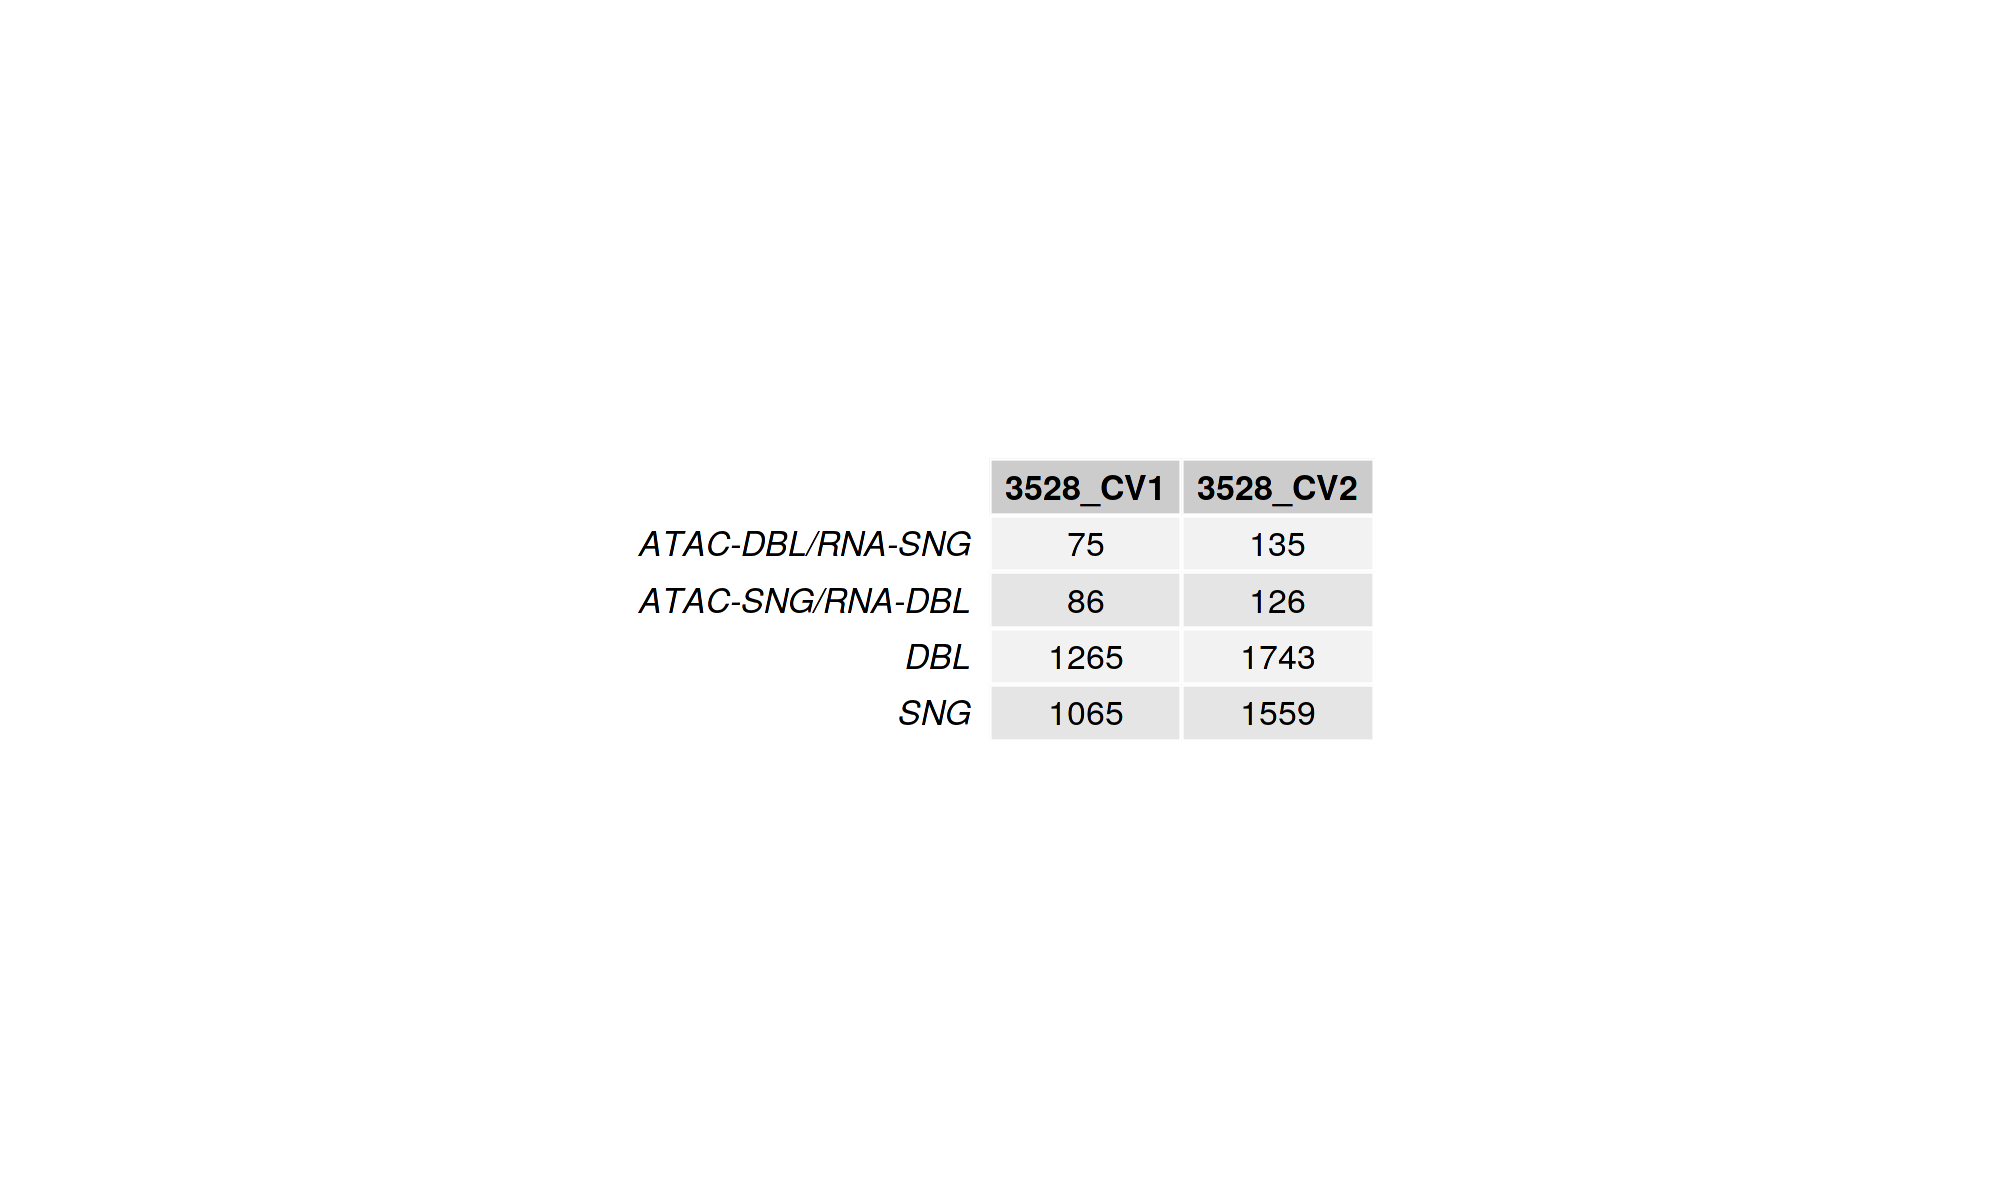

In [182]:
table(subset(demux_comb_df, Pass_QC)$Demux_both, subset(demux_comb_df, Pass_QC)$Sample) %>%
    gridExtra::grid.table()

In [193]:
table(
    subset(demux_comb_df, Pass_QC & Demux_both == "SNG")$ATAC_SNG.1ST,
    subset(demux_comb_df, Pass_QC & Demux_both == "SNG")$Sample
)

                       
                        3528_CV1 3528_CV2
  1_16191825-ND-25yM-SC      246      486
  2_16515959-ND-51yF-SC      271      315
  3_16550021-ND-50yF-SC      140      416
  5_AHKI007-HPAP074          377      250
  7_AHFK198-HPAP072_r         31       92

## Save barcodes corresponding to SNG and PASS QC

In [213]:
dir.create(glue("{root}/work/nuclei-qc/atac"), recursive = T, showWarnings = F)
dir.create(glue("{root}/work/nuclei-qc/rna"), recursive = T, showWarnings = F)
write.table(file = glue("{root}/work/nuclei-qc/atac/atac_barcodes_post-qc.txt"), subset(demux_comb_df, Pass_QC & Demux_both == "SNG")[, c("Barcode", "Sample")], col.names = F, row.names = F, quote = F)
write.table(file = glue("{root}/work/nuclei-qc/rna/rna_barcodes_post-qc.txt"), subset(demux_comb_df, Pass_QC & Demux_both == "SNG")[, c("rna_barcode", "Sample")], col.names = F, row.names = F, quote = F)


write.table(file = glue("{root}/work/nuclei-qc/metrics_allcols-barcodes_post-qc.txt"), subset(demux_comb_df, Pass_QC & Demux_both == "SNG"), col.names = T, row.names = F, quote = F)

# DropletUtils

In [ ]:
library(DropletUtils)
make_knee_plot <- function(br.out) {
    plot(br.out$rank, br.out$total, log="xy", xlab="Rank", ylab="Total")
o <- order(br.out$rank)
lines(br.out$rank[o], br.out$fitted[o], col="red")

abline(h=metadata(br.out)$knee, col="dodgerblue", lty=2)
abline(h=metadata(br.out)$inflection, col="forestgreen", lty=2)
legend("bottomleft", lty=2, col=c("dodgerblue", "forestgreen"), 
    legend=c("knee", "inflection"))
}

In [126]:
rna_10x_cv1 = read10xCounts("/lab/data/seqcore/3528-CV/10x_analysis_3528-CV/Sample_3528-CV-1/filtered_feature_bc_matrix", version='3', col.names=TRUE)
rna_10x_cv2 = read10xCounts("/lab/data/seqcore/3528-CV/10x_analysis_3528-CV/Sample_3528-CV-2/filtered_feature_bc_matrix", version='3', col.names=TRUE)

In [129]:
rna_cv1_out <- barcodeRanks(counts(rna_10x_cv1), lower=1000)
make_knee_plot(rna_cv1_out)

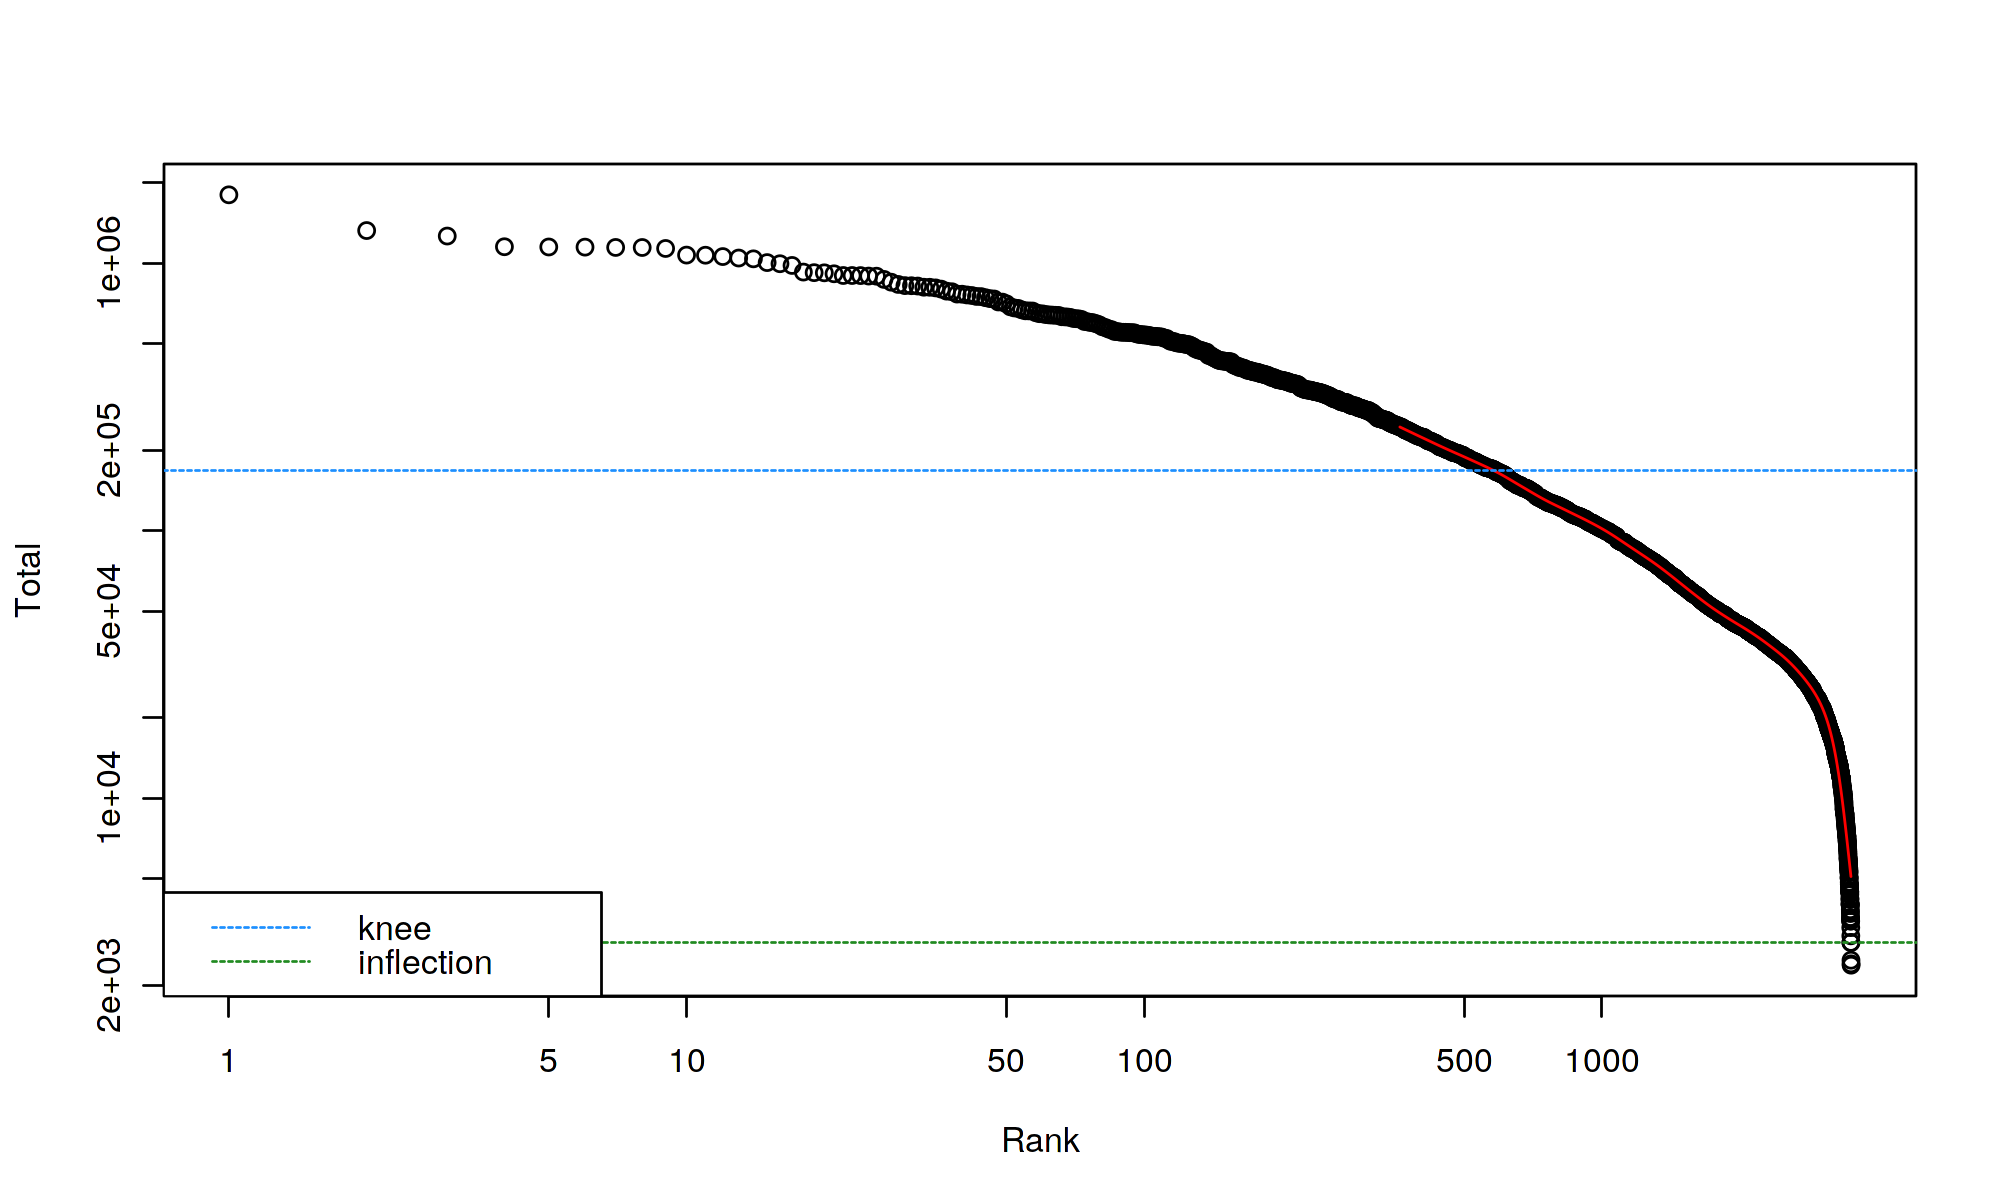

In [195]:
rna_cv2_out <- barcodeRanks(counts(rna_10x_cv2), lower=1000)
make_knee_plot(rna_cv2_out)

## Checking signal at marker genes

In [215]:
head(rna@raw.data)

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'head': object 'rna' not found


In [217]:
library(Matrix)


Attaching package: 'Matrix'


The following object is masked from 'package:S4Vectors':

    expand


The following objects are masked from 'package:tidyr':

    expand, pack, unpack


